* P2P图神经网络搭建

In [3]:
import numpy as np
import pandas as pd
import torch
#import torchvision
import torch.nn.functional as F
import dgl
import tqdm

In [ ]:
# p2p_info=pd.read_excel("D:\Data\P2P\P2P_ShutDownPlatform.xlsx")
# p2p_detail_1=pd.read_excel("D:\Data\P2P\P2P平台基本信息表_Raw.xlsx")
# p2p_detail_2=pd.read_excel("D:\Data\P2P\P2P平台日成交详情数据_Raw.xlsx")

In [186]:
def reduce(df):
	int_list = ['int', 'int32', 'int16']
	float_list = ['float', 'float32']
	for col in df.columns:
		col_type = df[col].dtypes
		if col_type in int_list:
			c_min = df[col].min()
			c_max = df[col].max()
			if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
				df[col] = df[col].astype(np.int8)
			elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
				df[col] = df[col].astype(np.int16)
			elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
				df[col] = df[col].astype(np.int32)
		elif col_type in float_list:
			c_min = df[col].min()
			c_max = df[col].max()
			if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
				df[col] = df[col].astype(np.float16)
			elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
				df[col] = df[col].astype(np.float32)
	return df

In [187]:
p2p_full_data=reduce(p2p_full_data)

In [188]:
p2p_full_data.to_pickle("D:\Data\P2P\P2P_FuLL.pkl")

In [ ]:
# p2p_info.columns

In [ ]:
# p2p_info=reduce(p2p_info)
# p2p_detail_1=reduce(p2p_detail_1)
# p2p_detail_2=reduce(p2p_detail_2)

In [4]:
p2p_info=pd.read_pickle("D:\Data\P2P\FullDailyShutDownInf0630.pkl")
p2p_detail_1=pd.read_pickle("D:\Data\P2P\P2P平台基本信息表_Raw.pkl")
p2p_detail_2=pd.read_pickle("D:\Data\P2P\P2P平台日成交详情数据_Raw.pkl")

In [1]:
import torch
import time
import math
import dgl
import numpy as np
import torch.nn as nn
from dgl.data import citation_graph as citegrh
from dgl import DGLGraph
import dgl.function as fn
import networkx as nx
import torch.nn.functional as F

from dgl.nn import GraphConv
import pycox
import sklearn
import datetime
import lifelines
# from dgl.nn.pytorch import GraphConv
# from dgl.nn.pytorch.conv import GraphConv

* survival bashline

因p2p_info中包含平台倒台的具体时间，通过merge过程能够实现对数据集的label

In [5]:
p2p_info.head()

,id,name,ShortName,operating_state,province_id,black_time,is_black,city_name,black_involve_money,black_involve_people,black_type,black_url,online_time,black_type_name,AdBlackType,is_click
0,5699,融益汇,ryhui,0,1,2019-12-28,2,北京市海淀区,NaN,NaN,10,https://www.p2peye.com/thread-2309539-1-1.html,2014-12-28,平台清盘,运营暂停或清理,1
1,4744,轻易贷,qingyidai,0,5,2019-12-13,2,河北省石家庄市,NaN,NaN,4,https://news.p2peye.com/article-554961-1.html,2014-10-25,警方介入,涉及司法或者介入,1
2,7803,车励享金服,clxchina,5,23,2019-12-3,1,陕西省西安市,NaN,NaN,0,https://www.p2peye.com/thread-2312866-1-1.html,2017-10-12,暂停运营,运营暂停或清理,1
3,3379,铜掌柜,tzg,0,12,2019-11-27,2,浙江省杭州市,NaN,NaN,10,https://news.p2peye.com/article-554297-1.html,2015-03-15,平台清盘,运营暂停或清理,1
4,402,麦子金服财富,nonobank,0,3,2019-11-23,2,上海市浦东新区,NaN,NaN,4,https://news.p2peye.com/article-554542-1.html,2009-06-15,警方介入,涉及司法或者介入,1


In [6]:
p2p_info_merge=p2p_info.iloc[:,[1,3,4,5,6,7,10,12,13,14]]

In [7]:
p2p_info_merge.loc[p2p_info_merge.name=="紫金贷"]

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType
5677,紫金贷,0,11,2014-05-20,2,江苏省淮安市,2,2012-12-12,提现困难,运营暂停或清理


In [50]:
p2p_full_data=p2p_info_merge.merge(p2p_detail_2,how="inner",left_on="name",right_on="FullName")

In [51]:
p2p_full_data

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingDate,PlatformID,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay
0,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,2017-07-28,217000003591,808.58,8.76,29,8.06,82,469952.42,825.91,9045.65
1,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,2017-07-29,217000003591,190.6,8.62,16,5.87,12,470040.22,87.8,8670.33
2,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,2017-07-30,217000003591,23.7,8.62,9,5.87,1,469997.56,-42.66,8602.3
3,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,2017-07-31,217000003591,101.3,8.62,17,5.87,9,470102.58,105.02,9912.56
4,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,2017-08-01,217000003591,725.6,8.62,57,5.87,44,470854.83,752.25,8709.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273565,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,2018-01-18,217000000169,0,0,0,0,0,6283.87,-45,2469.97
273566,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,2018-01-19,217000000169,0,0,0,0,0,6154.87,-129,2397.96
273567,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,2018-01-20,217000000169,0,0,0,0,0,6120.87,-34,2391.96
273568,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,2018-01-21,217000000169,0,0,0,0,0,6005.87,-115,2322.96


In [52]:
p2p_detail_2

,FullName,TradingDate,PlatformID,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay
0,平台名称,日期,平台ID,成交量_万元,平均利率(%),投资人数_人,平均借款期限_月,借款人数_人,累计待还金额_万元,近30日资金净流入_万元,未来60日待还_万元
1,神州通宝,2015-09-27,217000001577,50,9.8,33,3,1,7923.72,4.91,5217.78
2,宁创贷,2015-09-27,217000000160,0,0,0,0,0,5967.61,-81.49,2382.11
3,汇理财,2015-09-27,217000000091,195,12.35,63,4.89,2,33192.41,2172.53,10117.57
4,乐贷网,2015-09-27,217000000118,0,0,0,0,0,12551.19,424.87,5108.71
...,...,...,...,...,...,...,...,...,...,...,...
573879,e路同心,2020-06-24,217000000259,0,0,0,0,0,1991.87,-23.94,924.01
573880,新富创投,2020-06-24,217000004457,0,0,0,0,0,1801.41,-17.6,737.63
573881,首E家,2020-06-24,217000001767,0,0,0,0,0,10616.66,-100.69,1492.36
573882,互融宝,2020-06-24,217000000132,0,0,0,0,0,17269.22,-199.63,7341.53


In [53]:
p2p_detail_1.head()

,平台ID,平台,上线时间,更新日期,网址,注册资本_万元,平台背景,投资门槛,资金托管,风险准备金,保障方式,担保机构,承保金额_万元,自动投标,债券转让,业务类型,所在城市_省市,所在城市_辖区
0,217000000001,鑫合汇,2013-12-12,2016-07-19,http://www.xinhehui.com,5313.0,民营系,50元,"用户资金存管,托管机构为联动优势",无,保本保息,NaN,NaN,支持,2个月,银行过桥(80%),浙江,杭州
1,217000000001,鑫合汇,2013-12-12,2016-11-02,http://www.xinhehui.com,5313.0,民营系,50元,"用户资金托管,托管机构为联动优势",无,NaN,NaN,NaN,支持,2个月,银行过桥(80%),浙江,杭州
2,217000000001,鑫合汇,2013-12-12,2016-12-09,http://www.xinhehui.com,5313.0,民营系,50元,无,无,NaN,NaN,NaN,支持,2个月,担保标(100%),浙江,杭州
3,217000000001,鑫合汇,2013-12-12,2017-01-04,http://www.xinhehui.com,5313.0,民营系,1000元,无,无,NaN,NaN,NaN,支持,2个月,担保标(100%),浙江,杭州
4,217000000001,鑫合汇,2013-12-12,2017-01-20,http://www.xinhehui.com,5313.0,上市公司系,1000元,无,无,NaN,NaN,NaN,支持,2个月,担保标(100%),浙江,杭州


In [54]:
p2p_detail_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25294 entries, 0 to 25293
Data columns (total 18 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   平台ID     25294 non-null  int64  
 1   平台       25294 non-null  object 
 2   上线时间     25294 non-null  object 
 3   更新日期     25294 non-null  object 
 4   网址       18556 non-null  object 
 5   注册资本_万元  24570 non-null  float32
 6   平台背景     17340 non-null  object 
 7   投资门槛     6133 non-null   object 
 8   资金托管     7850 non-null   object 
 9   风险准备金    2777 non-null   object 
 10  保障方式     12727 non-null  object 
 11  担保机构     1844 non-null   object 
 12  承保金额_万元  1843 non-null   object 
 13  自动投标     17649 non-null  object 
 14  债券转让     17714 non-null  object 
 15  业务类型     12172 non-null  object 
 16  所在城市_省市  25294 non-null  object 
 17  所在城市_辖区  25283 non-null  object 
dtypes: float32(1), int64(1), object(16)
memory usage: 3.4+ MB


In [55]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay'],
      dtype='object')

In [56]:
p2p_full_data["black_time"]=pd.to_datetime(p2p_full_data["black_time"])

In [57]:
p2p_full_data["TradingDate"]=pd.to_datetime(p2p_full_data["TradingDate"])

In [58]:
p2p_full_data["online_time"]=pd.to_datetime(p2p_full_data["online_time"])

In [59]:
def timediff(a,b):
    return (b-a).days
dura=[]
for i in range (p2p_full_data.shape[0]):
    dura.append(timediff(p2p_full_data["online_time"][i],p2p_full_data["TradingDate"][i]))


In [60]:
def timediff_1(a,b):
    return (b-a).days<0

In [61]:
if_black=[]
for i in range(p2p_full_data.shape[0]):
    if_black.append(int(timediff_1(p2p_full_data["black_time"][i],p2p_full_data["TradingDate"][i])))

In [62]:
p2p_full_data["duration"]=dura

In [63]:
p2p_full_data["label"]=if_black

In [73]:
ts=p2p_full_data.loc[p2p_full_data.label==0]

In [70]:
ts.groupby(ts.name).describe()

operating_state                                    province_id        \
                count mean  std  min  25%  50%  75%  max       count  mean   
name                                                                         
365易贷           153.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       153.0  11.0   
51财融融           153.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       153.0  12.0   
91投               6.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0         6.0   3.0   
Hi投吧             44.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        44.0  20.0   
e兴金融             15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        15.0  22.0   
...               ...  ...  ...  ...  ...  ...  ...  ...         ...   ...   
雍和金融              1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0         1.0   1.0   
零用贷             142.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       142.0   3.0   
首鸿财富             19.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        19.0  12.0   
黄鹤金服             17.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0        17.0  18.0   
鼎信贷              90.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0        90.0  12.0   

       ... duration          label                                     
       ...      75%     max  count mean  std  min  25%  50%  75%  max  
name   ...                                                             
365易贷  ...  3226.00  3264.0  153.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
51财融融  ...   488.00   526.0  153.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
91投    ...   618.75   620.0    6.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
Hi投吧   ...   864.25   875.0   44.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
e兴金融   ...  1584.50  1588.0   15.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
...    ...      ...     ...    ...  ...  ...  ...  ...  ...  ...  ...  
雍和金融   ...  1777.00  1777.0    1.0  0.0  NaN  0.0  0.0  0.0  0.0  0.0  
零用贷    ...  1322.75  1358.0  142.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
首鸿财富   ...   724.50   729.0   19.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
黄鹤金服   ...   646.00   650.0   17.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
鼎信贷    ...  2184.75  2207.0   90.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[145 rows x 48 columns]

In [71]:
p2p_full_data.groupby(p2p_full_data.name).describe()

operating_state                                    province_id        \
                   count mean  std  min  25%  50%  75%  max       count  mean   
name                                                                            
1119贷                7.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0         7.0   4.0   
1818优本财富           621.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0       621.0   1.0   
360贷贷网             211.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       211.0  25.0   
365易贷             1098.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      1098.0  11.0   
51帮你               684.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       684.0  12.0   
...                  ...  ...  ...  ...  ...  ...  ...  ...         ...   ...   
黄鹤金服                39.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0        39.0  18.0   
黔商贷                950.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0       950.0  24.0   
鼎信贷               1121.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0      1121.0  12.0   
鼎诚创投               785.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       785.0  20.0   
鼠贷金融               496.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0       496.0   3.0   

          ... duration           label                                     \
          ...      75%     max   count      mean       std  min  25%  50%   
name      ...                                                               
1119贷     ...  1396.00  1398.0     7.0  1.000000  0.000000  1.0  1.0  1.0   
1818优本财富  ...   966.00  1134.0   621.0  1.000000  0.000000  1.0  1.0  1.0   
360贷贷网    ...   736.50   800.0   211.0  1.000000  0.000000  1.0  1.0  1.0   
365易贷     ...  2980.75  3264.0  1098.0  0.860656  0.346463  0.0  1.0  1.0   
51帮你      ...  1977.25  2156.0   684.0  1.000000  0.000000  1.0  1.0  1.0   
...       ...      ...     ...     ...       ...       ...  ...  ...  ...   
黄鹤金服      ...   640.50   650.0    39.0  0.564103  0.502356  0.0  0.0  1.0   
黔商贷       ...  1124.75  1370.0   950.0  1.000000  0.000000  1.0  1.0  1.0   
鼎信贷       ...  1919.00  2207.0  1121.0  0.919715  0.271856  0.0  1.0  1.0   
鼎诚创投      ...  1108.00  1308.0   785.0  1.000000  0.000000  1.0  1.0  1.0   
鼠贷金融      ...   978.25  1106.0   496.0  1.000000  0.000000  1.0  1.0  1.0   

                    
          75%  max  
name                
1119贷     1.0  1.0  
1818优本财富  1.0  1.0  
360贷贷网    1.0  1.0  
365易贷     1.0  1.0  
51帮你      1.0  1.0  
...       ...  ...  
黄鹤金服      1.0  1.0  
黔商贷       1.0  1.0  
鼎信贷       1.0  1.0  
鼎诚创投      1.0  1.0  
鼠贷金融      1.0  1.0  

[572 rows x 48 columns]

In [66]:
p2p_full_data.

1    266724
0      6846
Name: label, dtype: int64

In [75]:
ts.groupby(ts.black_type_name).describe()

operating_state                                     \
                          count mean  std  min  25%  50%  75%  max   
black_type_name                                                      
争议平台                      961.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
平台失联                      225.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
平台展期                      654.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
平台清盘                      765.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
提现困难                     1431.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
暂停运营                     1818.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0   
警方介入                      960.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
跑路平台                       32.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                province_id             ... duration           label       \
                      count       mean  ...      75%     max   count mean   
black_type_name                         ...                                 
争议平台                  961.0  10.449532  ...  1629.00  2207.0   961.0  0.0   
平台失联                  225.0   9.897778  ...  1151.00  1780.0   225.0  0.0   
平台展期                  654.0  14.651376  ...  1964.75  3689.0   654.0  0.0   
平台清盘                  765.0  16.101961  ...  2142.00  3264.0   765.0  0.0   
提现困难                 1431.0  12.582110  ...  1668.00  1976.0  1431.0  0.0   
暂停运营                 1818.0  11.770627  ...  1132.75  1608.0  1818.0  0.0   
警方介入                  960.0  15.721875  ...  1728.25  2815.0   960.0  0.0   
跑路平台                   32.0   1.000000  ...   750.25   760.0    32.0  0.0   

                                               
                 std  min  25%  50%  75%  max  
black_type_name                                
争议平台             0.0  0.0  0.0  0.0  0.0  0.0  
平台失联             0.0  0.0  0.0  0.0  0.0  0.0  
平台展期             0.0  0.0  0.0  0.0  0.0  0.0  
平台清盘             0.0  0.0  0.0  0.0  0.0  0.0  
提现困难             0.0  0.0  0.0  0.0  0.0  0.0  
暂停运营             0.0  0.0  0.0  0.0  0.0  0.0  
警方介入             0.0  0.0  0.0  0.0  0.0  0.0  
跑路平台             0.0  0.0  0.0  0.0  0.0  0.0  

[8 rows x 48 columns]

In [76]:
p2p_full_data.groupby(p2p_full_data.black_type_name).describe()

operating_state                                     \
                          count mean  std  min  25%  50%  75%  max   
black_type_name                                                      
争议平台                     7699.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
平台失联                    34031.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
平台展期                    19918.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
平台清盘                    54189.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
提现困难                    45897.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
暂停运营                    32194.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0   
警方介入                    76633.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
跑路平台                     2081.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

                province_id             ... duration            label  \
                      count       mean  ...      75%     max    count   
black_type_name                         ...                             
争议平台                 7699.0   8.161579  ...   1363.5  2207.0   7699.0   
平台失联                34031.0  11.997826  ...   1020.0  2127.0  34031.0   
平台展期                19918.0  10.053620  ...   1502.0  3689.0  19918.0   
平台清盘                54189.0  13.750503  ...   1327.0  3264.0  54189.0   
提现困难                45897.0  10.002440  ...   1215.0  2156.0  45897.0   
暂停运营                32194.0  10.890725  ...   1133.0  2017.0  32194.0   
警方介入                76633.0  13.028826  ...   1408.0  3618.0  76633.0   
跑路平台                 2081.0   7.920711  ...   1395.0  1717.0   2081.0   

                                                              
                     mean       std  min  25%  50%  75%  max  
black_type_name                                               
争议平台             0.875179  0.330538  0.0  1.0  1.0  1.0  1.0  
平台失联             0.993388  0.081044  0.0  1.0  1.0  1.0  1.0  
平台展期             0.967165  0.178208  0.0  1.0  1.0  1.0  1.0  
平台清盘             0.985883  0.117975  0.0  1.0  1.0  1.0  1.0  
提现困难             0.968821  0.173802  0.0  1.0  1.0  1.0  1.0  
暂停运营             0.943530  0.230831  0.0  1.0  1.0  1.0  1.0  
警方介入             0.987473  0.111223  0.0  1.0  1.0  1.0  1.0  
跑路平台             0.984623  0.123077  0.0  1.0  1.0  1.0  1.0  

[8 rows x 48 columns]

In [81]:
object_list=[]
for name in p2p_full_data.columns.values:
    if p2p_full_data[name].dtype==object:
        object_list.append(name)

In [83]:
p2p_full_data.head()

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label
0,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,808.58,8.76,29,8.06,82,469952.42,825.91,9045.65,1007.0,1
1,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,190.6,8.62,16,5.87,12,470040.22,87.8,8670.33,1008.0,1
2,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,23.7,8.62,9,5.87,1,469997.56,-42.66,8602.3,1009.0,1
3,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,101.3,8.62,17,5.87,9,470102.58,105.02,9912.56,1010.0,1
4,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,725.6,8.62,57,5.87,44,470854.83,752.25,8709.83,1011.0,1


In [85]:
p2p_full_data["TradingVolume"]=p2p_full_data["TradingVolume"].apply(lambda x:int(x))

In [89]:
p2p_full_data["AveReturn"]=p2p_full_data["AveReturn"].apply(lambda x:int(x))

In [90]:
p2p_full_data["InvestorNum"]=p2p_full_data["InvestorNum"].apply(lambda x:int(x))

In [103]:
p2p_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273570 entries, 0 to 273569
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   name             273570 non-null  object        
 1   operating_state  273570 non-null  int64         
 2   province_id      273570 non-null  int64         
 3   black_time       273570 non-null  datetime64[ns]
 4   is_black         273570 non-null  int64         
 5   city_name        273570 non-null  object        
 6   black_type       273570 non-null  int64         
 7   online_time      270662 non-null  datetime64[ns]
 8   black_type_name  272642 non-null  object        
 9   AdBlackType      273570 non-null  object        
 10  FullName         273570 non-null  object        
 11  TradingDate      273570 non-null  datetime64[ns]
 12  PlatformID       273570 non-null  object        
 13  TradingVolume    273570 non-null  int64         
 14  AveReturn        273

In [106]:
p2p_full_data

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label
0,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,808,8,29,8,82,469952.42,825.91,9045.65,1007.0,1
1,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,190,8,16,5,12,470040.22,87.8,8670.33,1008.0,1
2,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,23,8,9,5,1,469997.56,-42.66,8602.3,1009.0,1
3,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,101,8,17,5,9,470102.58,105.02,9912.56,1010.0,1
4,轻易贷,0,5,2019-12-13,2,河北省石家庄市,4,2014-10-25,警方介入,涉及司法或者介入,...,725,8,57,5,44,470854.83,752.25,8709.83,1011.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273565,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,0,0,0,0,0,6283.87,-45,2469.97,1165.0,0
273566,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,0,0,0,0,0,6154.87,-129,2397.96,1166.0,0
273567,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,0,0,0,0,0,6120.87,-34,2391.96,1167.0,0
273568,今时贷,5,15,2018-01-08,1,江西省南昌市,0,2014-11-10,暂停运营,运营暂停或清理,...,0,0,0,0,0,6005.87,-115,2322.96,1168.0,0


In [107]:
from numpy import NaN


def switch(a):
    p2p_full_data[a]=p2p_full_data[a].apply(lambda x:float(x) if x!=NaN else x)

for i in range(9,14):
    switch(object_list[i])

In [82]:
object_list

['name',
 'city_name',
 'black_type_name',
 'AdBlackType',
 'FullName',
 'PlatformID',
 'TradingVolume',
 'AveReturn',
 'InvestorNum',
 'AveLimTime',
 'LoanNum',
 'CumulateRepay',
 'F30Repay',
 'F60Repay']

In [108]:
p2p_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273570 entries, 0 to 273569
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   name             273570 non-null  object        
 1   operating_state  273570 non-null  int64         
 2   province_id      273570 non-null  int64         
 3   black_time       273570 non-null  datetime64[ns]
 4   is_black         273570 non-null  int64         
 5   city_name        273570 non-null  object        
 6   black_type       273570 non-null  int64         
 7   online_time      270662 non-null  datetime64[ns]
 8   black_type_name  272642 non-null  object        
 9   AdBlackType      273570 non-null  object        
 10  FullName         273570 non-null  object        
 11  TradingDate      273570 non-null  datetime64[ns]
 12  PlatformID       273570 non-null  object        
 13  TradingVolume    273570 non-null  int64         
 14  AveReturn        273

In [109]:
from sklearn.preprocessing import LabelEncoder
def labelencoder(a):
    encoder=LabelEncoder().fit(p2p_full_data[a])
    p2p_full_data[a]=encoder.transform(p2p_full_data[a])

for a in ['city_name','black_type_name','AdBlackType']:
    labelencoder(a)

In [111]:
p2p_full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 273570 entries, 0 to 273569
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   name             273570 non-null  object        
 1   operating_state  273570 non-null  int64         
 2   province_id      273570 non-null  int64         
 3   black_time       273570 non-null  datetime64[ns]
 4   is_black         273570 non-null  int64         
 5   city_name        273570 non-null  int32         
 6   black_type       273570 non-null  int64         
 7   online_time      270662 non-null  datetime64[ns]
 8   black_type_name  273570 non-null  int32         
 9   AdBlackType      273570 non-null  int32         
 10  FullName         273570 non-null  object        
 11  TradingDate      273570 non-null  datetime64[ns]
 12  PlatformID       273570 non-null  object        
 13  TradingVolume    273570 non-null  int64         
 14  AveReturn        273

In [149]:
test=p2p_full_data.loc[p2p_full_data.name=="轻易贷"]

* 利用seanborn完成图形绘制

In [136]:
test=p2p_full_data.columns

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [176]:
test

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label
0,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,808,8,29,8.0,82.0,469952.42,825.91,9045.65,1007.0,1
1,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,190,8,16,5.0,12.0,470040.22,87.80,8670.33,1008.0,1
2,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,23,8,9,5.0,1.0,469997.56,-42.66,8602.30,1009.0,1
3,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,101,8,17,5.0,9.0,470102.58,105.02,9912.56,1010.0,1
4,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,725,8,57,5.0,44.0,470854.83,752.25,8709.83,1011.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
819,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,866,8,747,4.0,62.0,741543.21,-7490.01,308493.05,1870.0,1
820,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,8894,8,6686,4.0,929.0,738171.99,-3371.22,299993.55,1871.0,1
821,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,8541,8,8725,4.0,793.0,740478.52,2306.53,295821.10,1872.0,1
822,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,7005,8,6521,4.0,764.0,745492.73,5014.21,298069.30,1873.0,1


In [7]:
import numpy as np
import pandas as pd
import seaborn as sns

In [67]:
p2p_full_data=pd.read_pickle("D:\Data\P2P\P2P_FuLL.pkl")

In [8]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

In [9]:
p2p_full_data.head()

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label
0,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,808,8,29,8.0,82.0,469952.40625,825.909973,9045.650391,1007.0,1
1,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,190,8,16,5.0,12.0,470040.21875,87.800003,8670.330078,1008.0,1
2,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,23,8,9,5.0,1.0,469997.56250,-42.660000,8602.299805,1009.0,1
3,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,101,8,17,5.0,9.0,470102.59375,105.019997,9912.559570,1010.0,1
4,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,725,8,57,5.0,44.0,470854.84375,752.250000,8709.830078,1011.0,1


<AxesSubplot:xlabel='TradingDate', ylabel='F30Repay'>

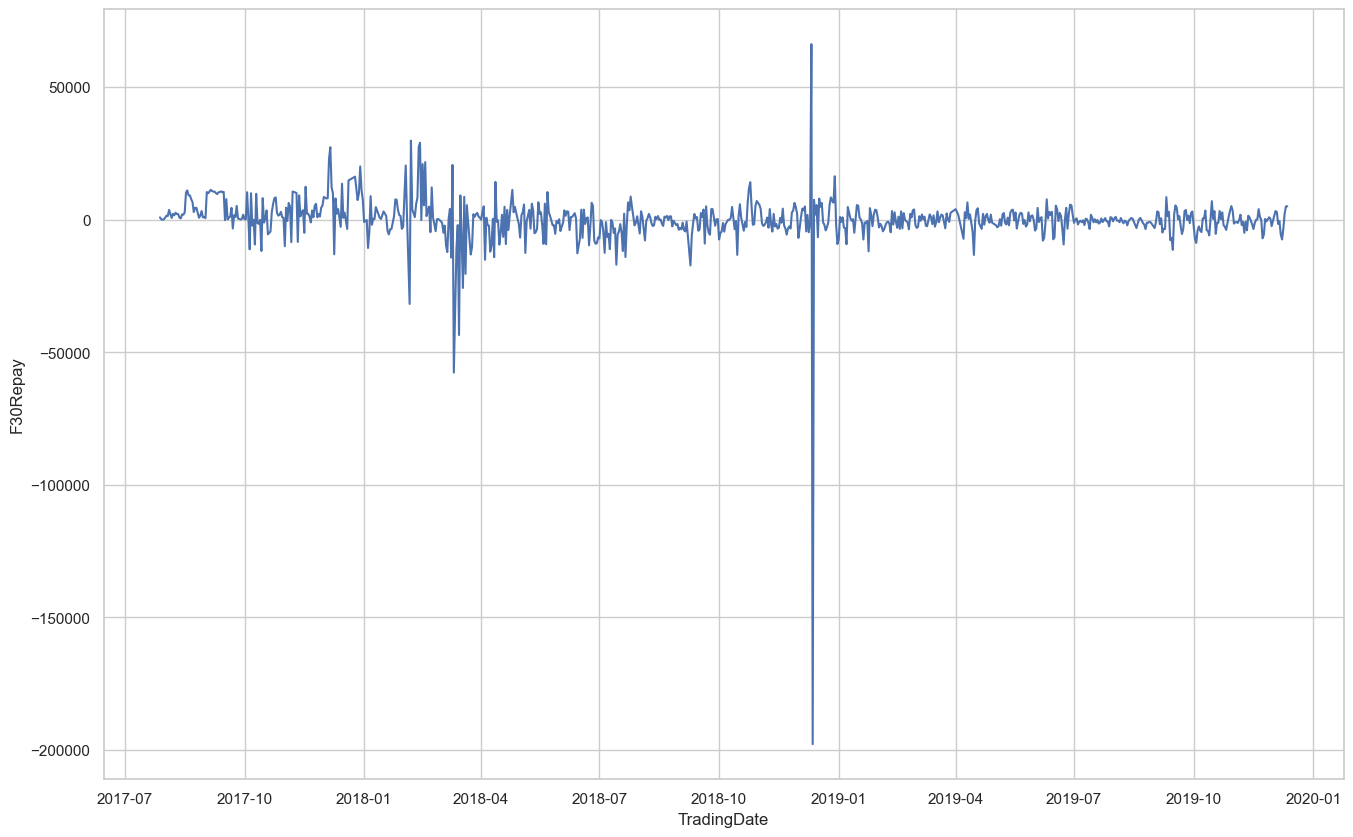

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sns.lineplot(data=p2p_full_data.loc[p2p_full_data.name=="轻易贷"],x="TradingDate",y="F30Repay")

<AxesSubplot:xlabel='TradingDate', ylabel='F60Repay'>

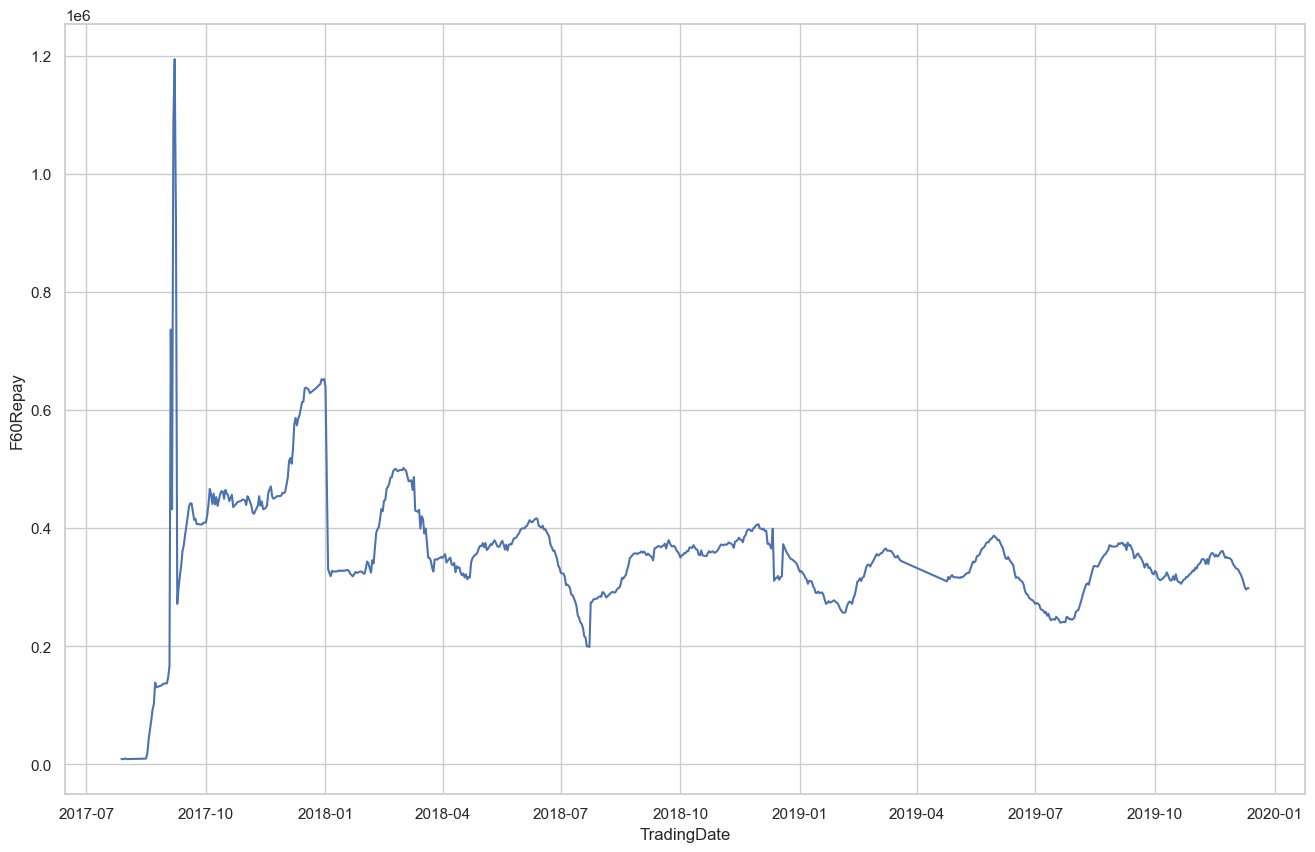

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
sns.lineplot(data=p2p_full_data.loc[p2p_full_data.name=="轻易贷"],x="TradingDate",y="F60Repay")

In [27]:
plt.rcParams['font.sans-serif']=['SimHei']

<AxesSubplot:xlabel='TradingDate', ylabel='F60Repay'>

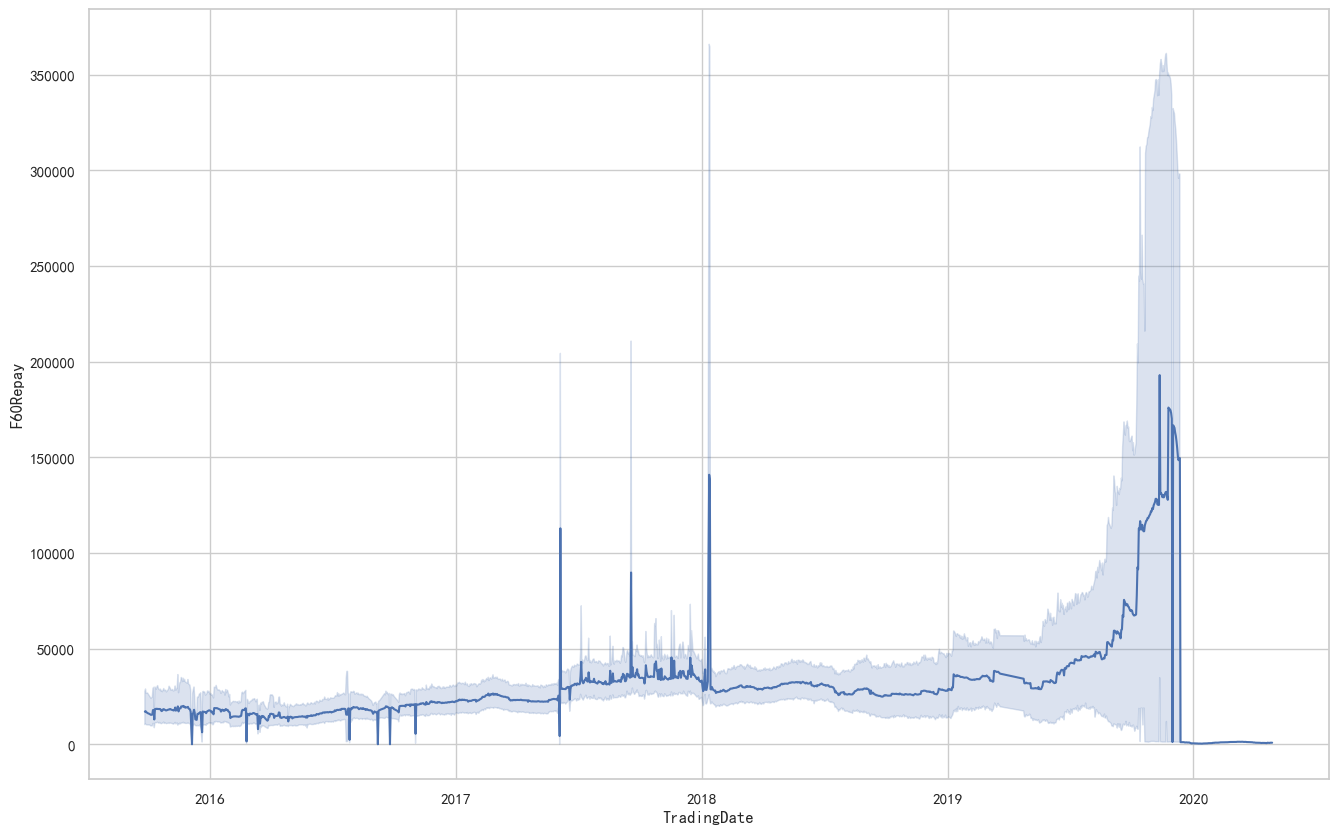

In [36]:
from matplotlib.font_manager import FontProperties


plt.figure(figsize=(16,10))
sns.lineplot(data=p2p_full_data,x="TradingDate",y="F60Repay")

In [29]:
p2p_full_data.head()

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label
0,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,808,8,29,8.0,82.0,469952.40625,825.909973,9045.650391,1007.0,1
1,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,190,8,16,5.0,12.0,470040.21875,87.800003,8670.330078,1008.0,1
2,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,23,8,9,5.0,1.0,469997.56250,-42.660000,8602.299805,1009.0,1
3,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,101,8,17,5.0,9.0,470102.59375,105.019997,9912.559570,1010.0,1
4,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,725,8,57,5.0,44.0,470854.84375,752.250000,8709.830078,1011.0,1


In [31]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

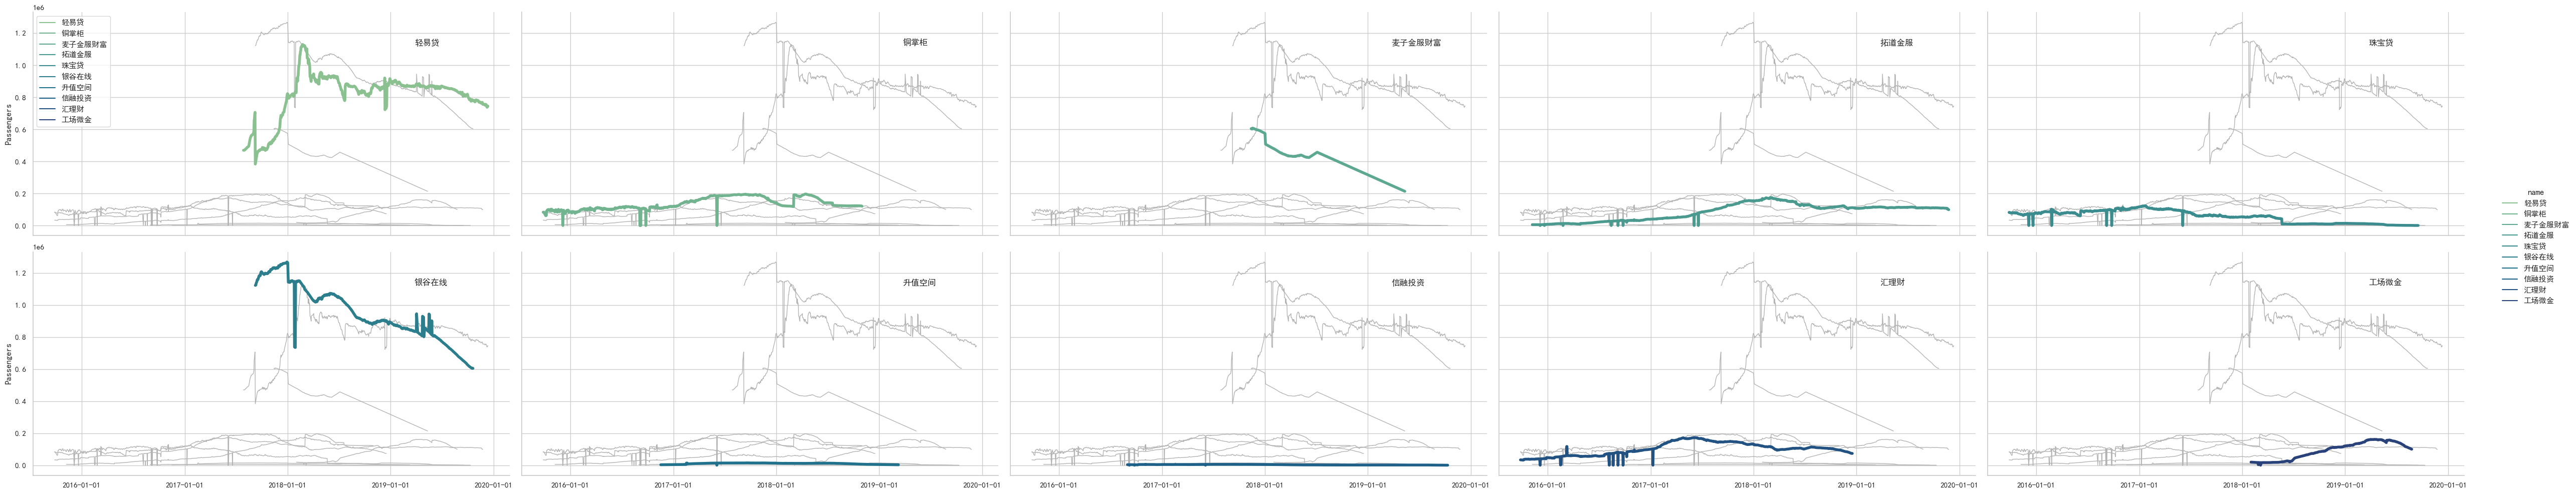

In [56]:
g = sns.relplot(
    data=p2p_test,
    x="TradingDate", y="CumulateRepay", col="name",hue="name",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col_wrap=5, height=5, aspect=2, legend=True,
)

# Iterate over each subplot to customize further
for year, ax in g.axes_dict.items():

    # Add the title as an annotation within the plot
    ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Plot every year's time series in the background
    sns.lineplot(
        data=p2p_test, x="TradingDate", y="CumulateRepay",units="name",
        estimator=None, color=".7", linewidth=1, ax=ax,
    )

# Reduce the frequency of the x axis ticks
ax.set_xticks(ax.get_xticks()[::2])

# Tweak the supporting aspects of the plot
g.set_titles("")
g.set_axis_labels("", "Passengers")
g.tight_layout()

In [42]:
p2p_name=p2p_full_data.name.unique()[:10]

In [73]:
p2p_test=p2p_full_data.loc[p2p_full_data.name.isin(p2p_name)]

In [44]:
p2p_test

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label
0,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,808,8,29,8.0,82.0,469952.406250,825.909973,9045.650391,1007.0,1
1,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,190,8,16,5.0,12.0,470040.218750,87.800003,8670.330078,1008.0,1
2,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,23,8,9,5.0,1.0,469997.562500,-42.660000,8602.299805,1009.0,1
3,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,101,8,17,5.0,9.0,470102.593750,105.019997,9912.559570,1010.0,1
4,轻易贷,0,5,2019-12-13,2,66,4,2014-10-25,6,2,...,725,8,57,5.0,44.0,470854.843750,752.250000,8709.830078,1011.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9023,工场微金,0,1,2019-10-16,2,17,11,2012-07-01,2,3,...,0,0,0,0.0,0.0,103351.382812,-1167.550049,31324.630859,2608.0,1
9024,工场微金,0,1,2019-10-16,2,17,11,2012-07-01,2,3,...,0,0,0,0.0,0.0,102401.937500,-949.429993,30586.240234,2608.0,1
9025,工场微金,0,1,2019-10-16,2,17,11,2012-07-01,2,3,...,0,0,0,0.0,0.0,101301.468750,-1100.469971,29596.119141,2608.0,1
9026,工场微金,0,1,2019-10-16,2,17,11,2012-07-01,2,3,...,0,0,0,0.0,0.0,100443.960938,-857.520020,29146.630859,2610.0,1


In [64]:
p2p_test_1=p2p_test.copy()
p2p_test["TradingDate"]=p2p_test["TradingDate"].apply(lambda x:str(x)[:10])

C:\Users\zhouda\AppData\Local\Temp\ipykernel_20780\4179643024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p2p_test["TradingDate"]=p2p_test["TradingDate"].apply(lambda x:str(x)[:10])


<AxesSubplot:xlabel='TradingDate', ylabel='CumulateRepay'>

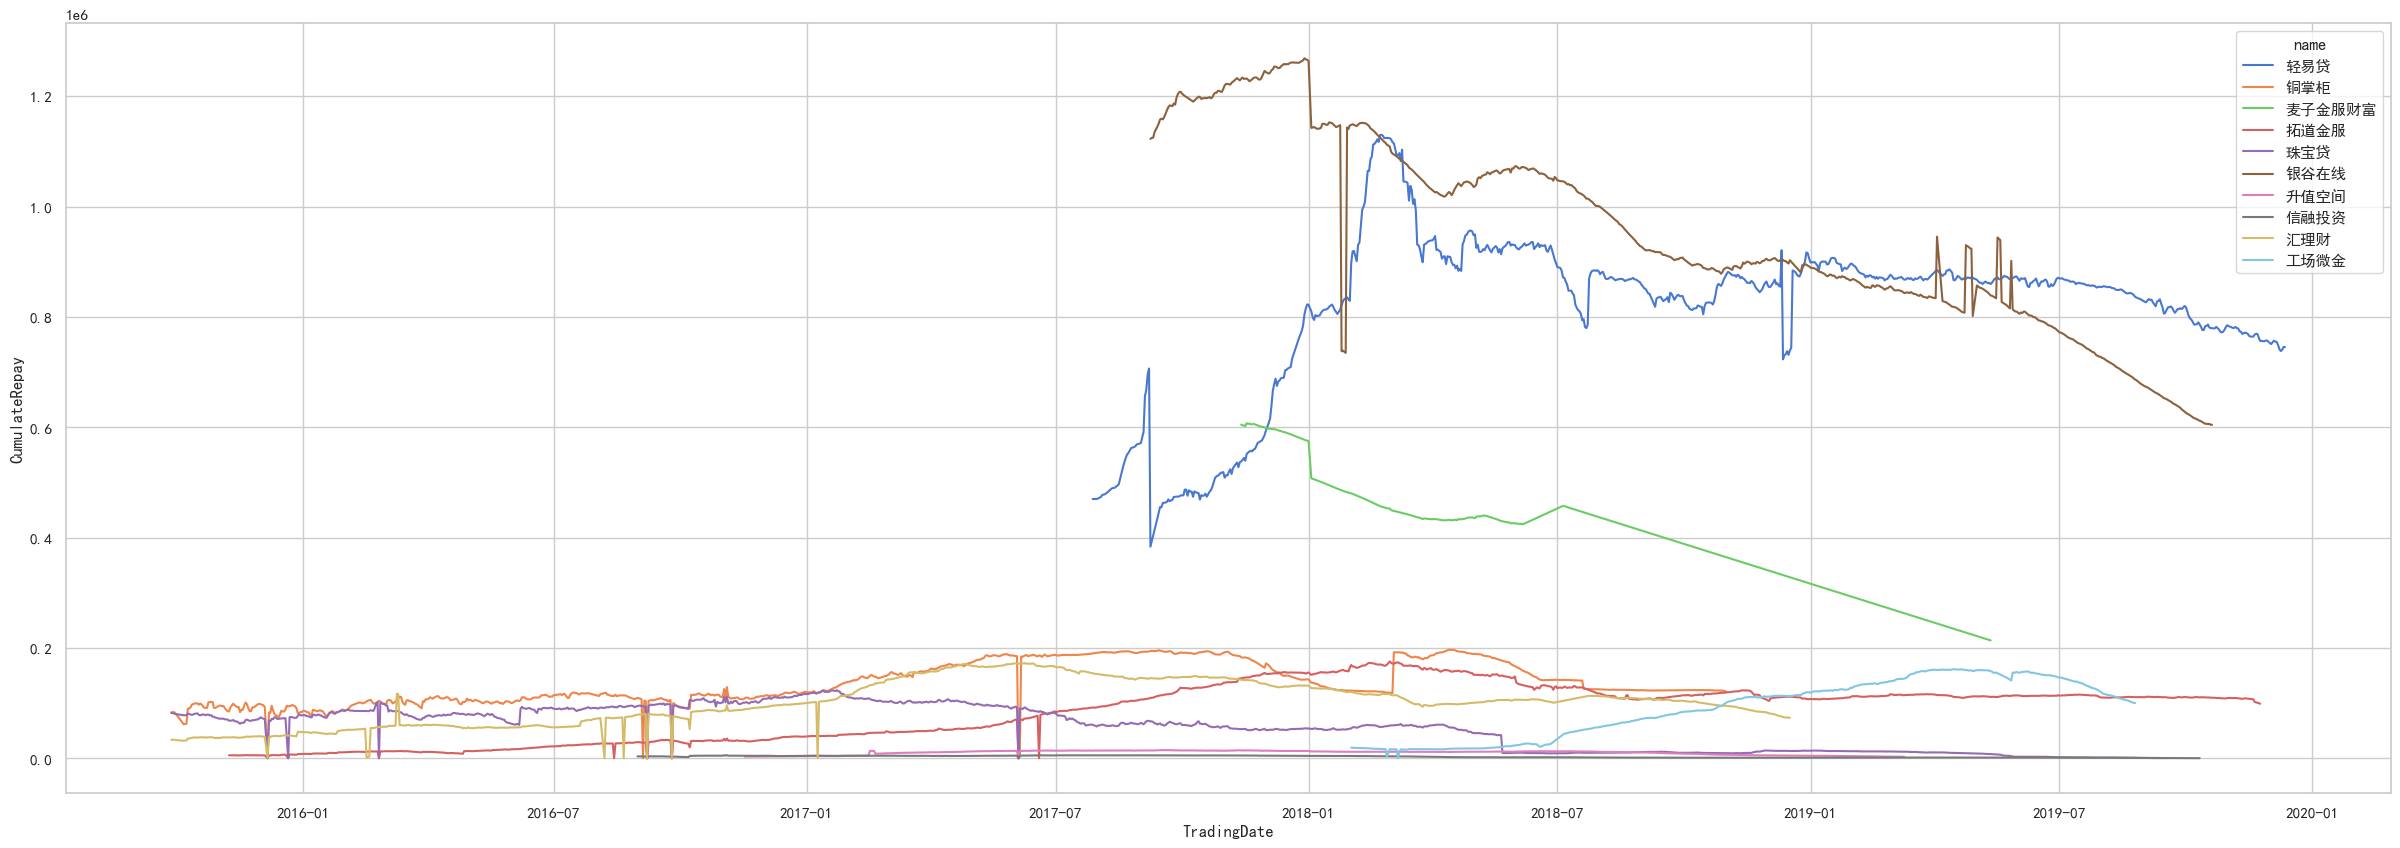

In [74]:
plt.figure(figsize=(30,10))
sns.lineplot(x="TradingDate",y="CumulateRepay",hue="name",data=p2p_test,ci=None, palette="muted")

In [75]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

<AxesSubplot:xlabel='F30Repay', ylabel='F60Repay'>

d:\Anaconda\envs\limu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


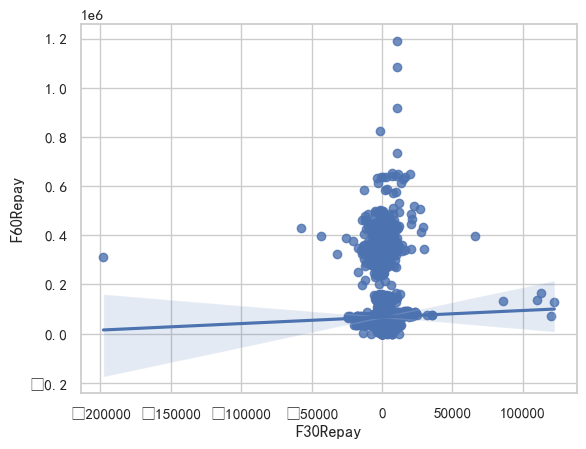

In [77]:
sns.regplot(x="F30Repay",y="F60Repay",data=p2p_test)

<AxesSubplot:xlabel='duration', ylabel='CumulateRepay'>

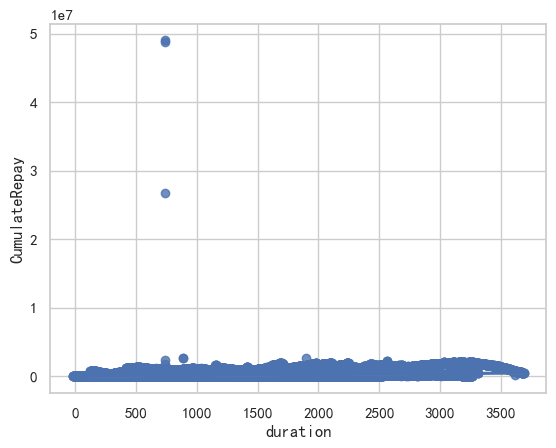

In [78]:
sns.regplot(x="duration",y="CumulateRepay",data=p2p_full_data)

In [79]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

   operating_state  province_id black_time  is_black  city_name  black_type  \
0                0            5 2019-12-13         2         66           4   
1                0            5 2019-12-13         2         66           4   
2                0            5 2019-12-13         2         66           4   
3                0            5 2019-12-13         2         66           4   
4                0            5 2019-12-13         2         66           4   

  online_time  AdBlackType TradingDate    PlatformID  TradingVolume  \
0  2014-10-25            2  2017-07-28  217000003591            808   
1  2014-10-25            2  2017-07-29  217000003591            190   
2  2014-10-25            2  2017-07-30  217000003591             23   
3  2014-10-25            2  2017-07-31  217000003591            101   
4  2014-10-25            2  2017-08-01  217000003591            725   

   AveReturn  InvestorNum  AveLimTime  LoanNum  CumulateRepay    F30Repay  \
0          8         

d:\Anaconda\envs\limu\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


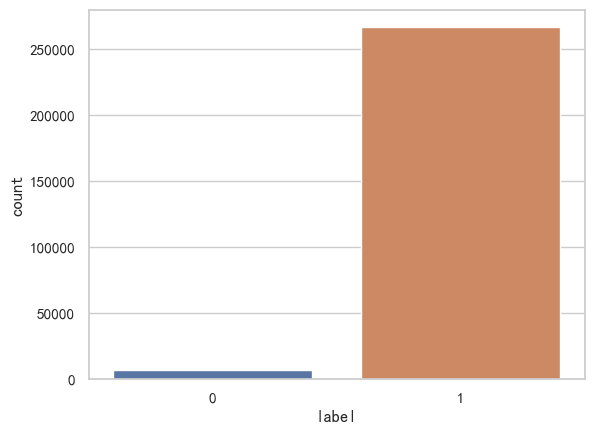

d:\Anaconda\envs\limu\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.draw()
d:\Anaconda\envs\limu\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


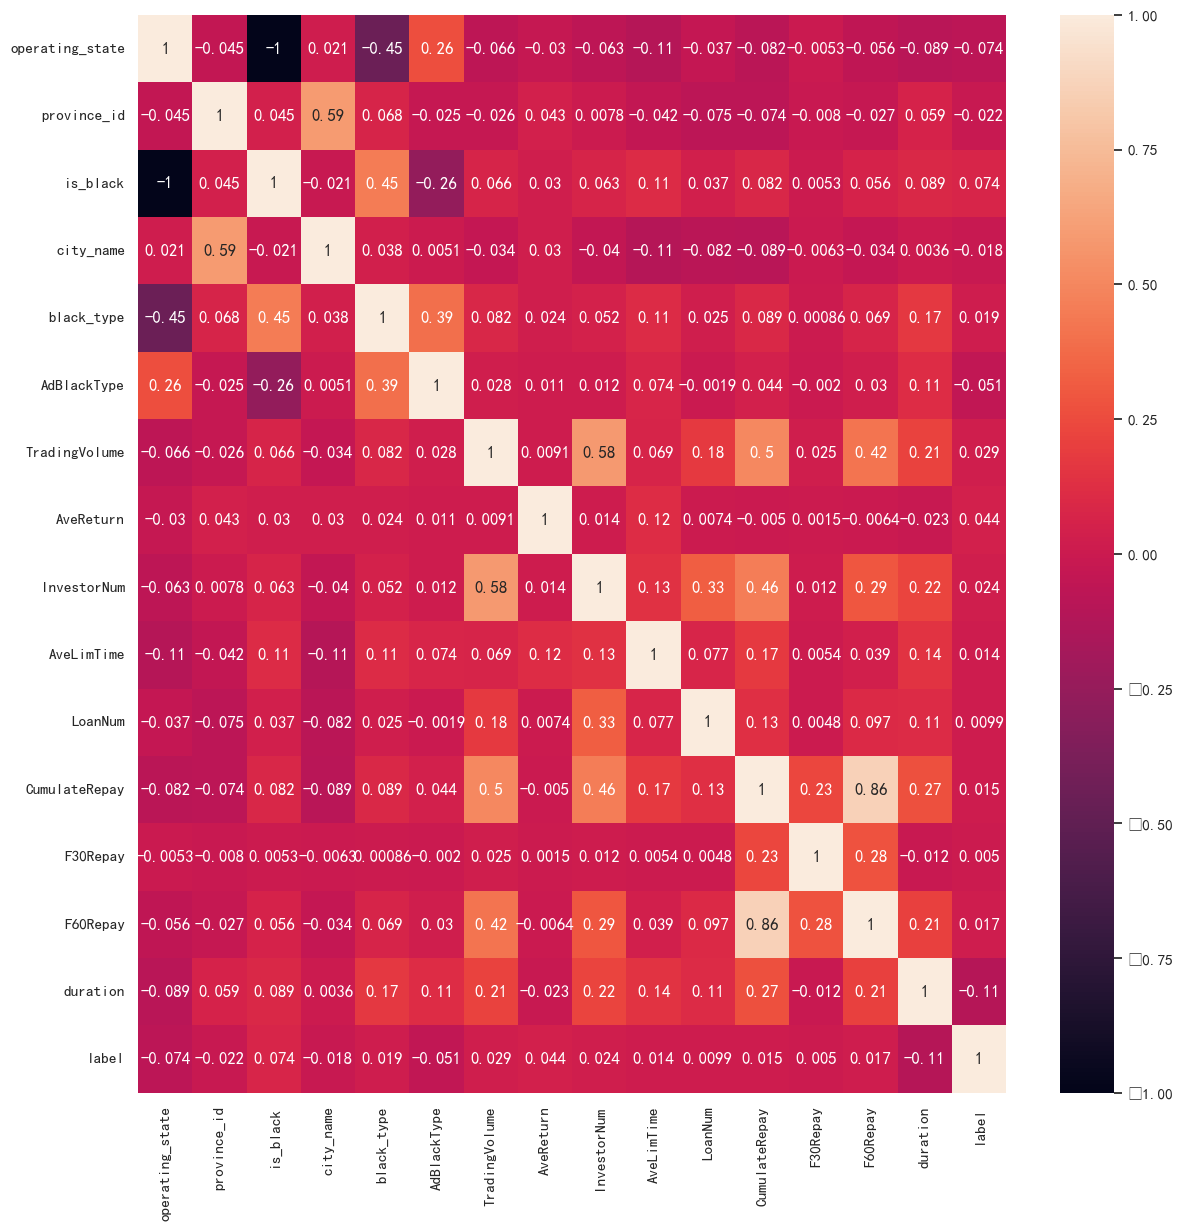

In [83]:
data=p2p_full_data
# 特征分为3组
#data.drop('name',axis=1,inplace=True)
#data.drop('black_type_name',axis=1,inplace=True)
#data.drop('FullName',axis=1,inplace=True)
# 将B良性替换为0，M恶性替换为1

print(data.head(5))

# 4. 特征选择
# 目的  降维
sns.countplot(data['label'],label='Count')
plt.show()

# 热力图features_mean 字段之间的相关性
corr = data.corr()
plt.figure(figsize=(14,14))

sns.heatmap(corr,annot=True)
plt.show()



* 生存分析经典模型分析

In [85]:
import lifelines 
from lifelines import CoxPHFitter

In [91]:
p2p_full_data["online_year"]=p2p_full_data["online_time"].apply(lambda x:x.year)

In [93]:
p2p_full_data["black_year"]=p2p_full_data["black_time"].apply(lambda x:x.year)

In [86]:
p2p_full_data.columns

Index(['operating_state', 'province_id', 'black_time', 'is_black', 'city_name',
       'black_type', 'online_time', 'AdBlackType', 'TradingDate', 'PlatformID',
       'TradingVolume', 'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum',
       'CumulateRepay', 'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

<AxesSubplot:xlabel='black_type', ylabel='count'>

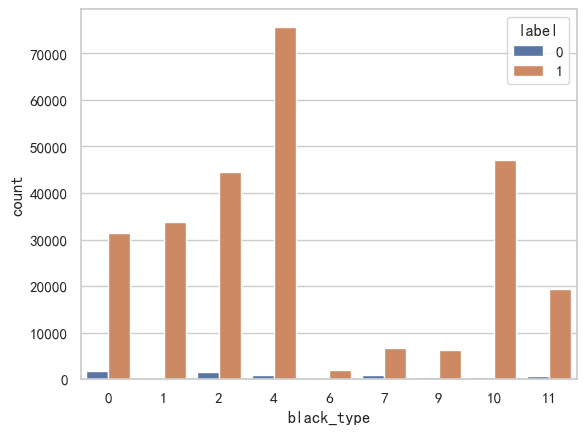

In [87]:
#不同T(肿瘤大小)分期，删失人数和死亡人数的柱状分布图
sns.countplot(x="black_type",hue="label",data=p2p_full_data)


<AxesSubplot:xlabel='province_id', ylabel='count'>

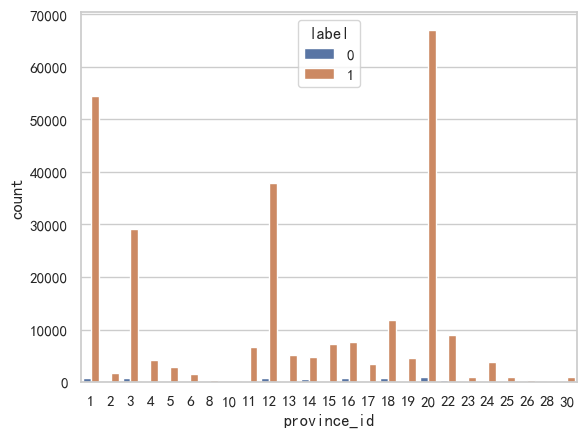

In [88]:
sns.countplot(x="province_id",hue="label",data=p2p_full_data)

<AxesSubplot:xlabel='online_year', ylabel='count'>

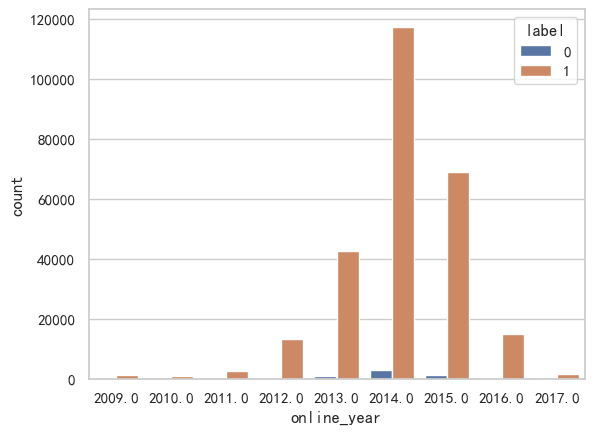

In [92]:
sns.countplot(x="online_year",hue="label",data=p2p_full_data)

<AxesSubplot:xlabel='black_year', ylabel='count'>

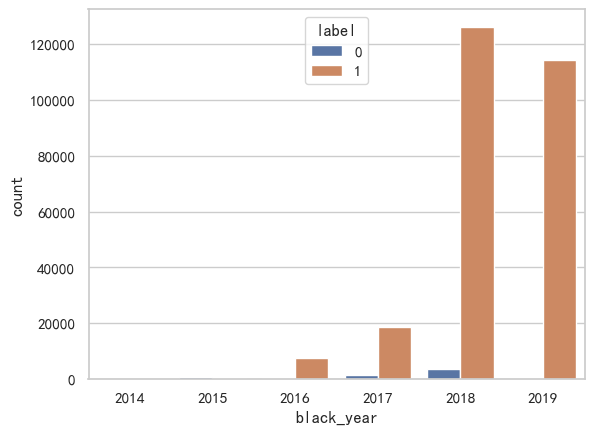

In [94]:
sns.countplot(x="black_year",hue="label",data=p2p_full_data)

[Text(1, 0, 'censor'), Text(2, 0, 'death')]

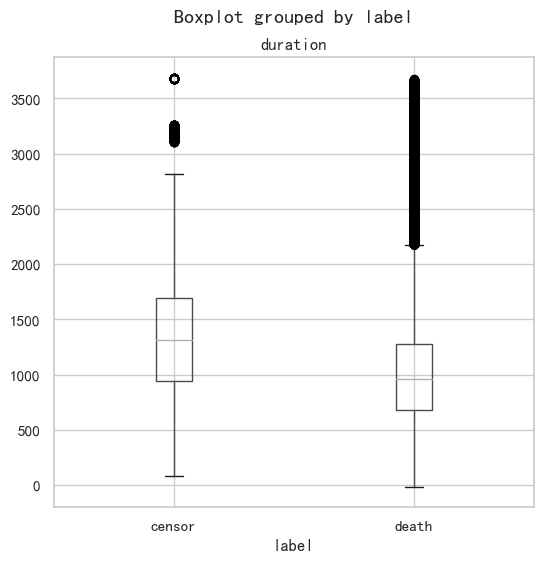

In [98]:
ax = p2p_full_data.boxplot(column='duration',by="label",figsize=(6,6))
ax.set_xticklabels(["censor","death"])

* #TODO 现存duration存在差异，即在平台死亡后，duration计算指标仍然会增加，会导致死亡平台的duration估计值偏大。

d:\Anaconda\envs\limu\lib\site-packages\matplotlib\axes\_base.py:2480: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


Text(0.5, 0, 'Days')

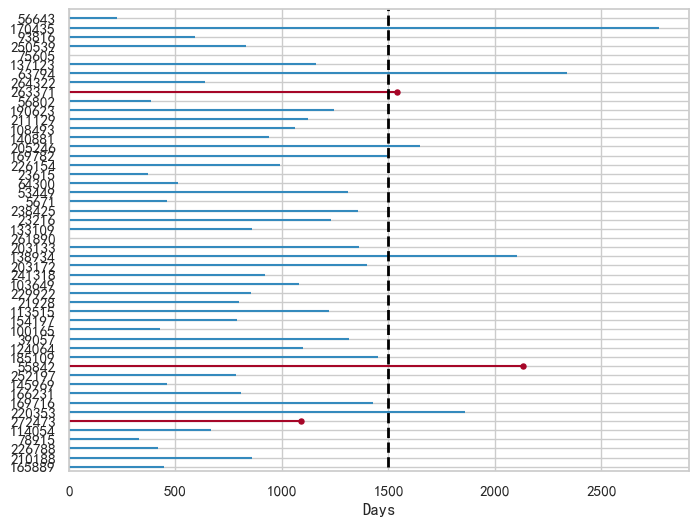

In [115]:
from lifelines.plotting import plot_lifetimes
df_sample = p2p_full_data.sample(n=50,random_state=60)
df_sample['label'] = np.where(df_sample['label']== 1,False,True)
plt.figure(figsize=[8,6])
ax = plot_lifetimes(df_sample['duration'], event_observed=df_sample['label'],sort_by_duration=False)
ax.vlines(1500, 0, 50, lw=2, linestyles='--',colors='black')
plt.xlabel("Days")

In [16]:
# from sklearn.impute import SimpleImputer
# imput_1=SimpleImputer(missing_values=np.nan,strategy="median")
# imput_1.fit(p2p_full_data)

ValueError: Cannot use median strategy with non-numeric data:
could not convert string to float: '轻易贷'

In [20]:
p2p_full_data.loc[p2p_full_data.duration==None]

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label


In [68]:
p2p_full_data["label"]=np.where(p2p_full_data["label"]==1,0,1)

In [25]:
from lifelines.utils import survival_table_from_events

#原本数据是生存时间是以月位单位的，现在特意计算成以年位单位，然后制作寿命表
def months_to_year(x):
    if x % 30 ==0:
        return x /30
    else:
        return x//30+1 
p2p_full_data['survival_year'] = p2p_full_data['duration'].map(months_to_year)
T = p2p_full_data['survival_year']
E = p2p_full_data['label']
table=survival_table_from_events(T, E,columns=['removed', 'observed', 'censored', 'entrance', 'at_risk'])


In [33]:
table.reset_index(inplace=True)

In [34]:
table=pd.DataFrame(table)

In [35]:
x = table["event_at"]

In [42]:
table["probability_of_death"]=table["removed"]/(table["at_risk"]-table["censored"]/2)
table["probability_of_surviving"]=1- table["probability_of_death"]
k=0
table["survival_rate"]=0
for i in range(table.shape[0]):
    if i==0:
        table["survival_rate"][i]=table["probability_of_surviving"][i]
        k=table["probability_of_surviving"][i]
    else:
        k=k*table["probability_of_surviving"][i]
        table["survival_rate"][i]=k


C:\Users\zhouda\AppData\Local\Temp\ipykernel_16212\2602322581.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table["survival_rate"][i]=table["probability_of_surviving"][i]


In [48]:
table

,event_at,removed,observed,censored,entrance,at_risk,probability_of_death,probability_of_surviving,survival_rate
0,0.0,21,0,21,273570,273570,0.000077,0.999923,0.999923
1,1.0,74,0,74,0,273549,0.000271,0.999729,0.999653
2,2.0,124,0,124,0,273475,0.000454,0.999546,0.999199
3,3.0,294,7,287,0,273351,0.001076,0.998924,0.998124
4,4.0,428,0,428,0,273057,0.001569,0.998431,0.996558
...,...,...,...,...,...,...,...,...,...
119,119.0,29,0,29,0,3048,0.009560,0.990440,0.009746
120,120.0,31,0,31,0,3019,0.010321,0.989679,0.009646
121,121.0,30,0,30,0,2988,0.010091,0.989909,0.009548
122,122.0,26,0,26,0,2958,0.008829,0.991171,0.009464


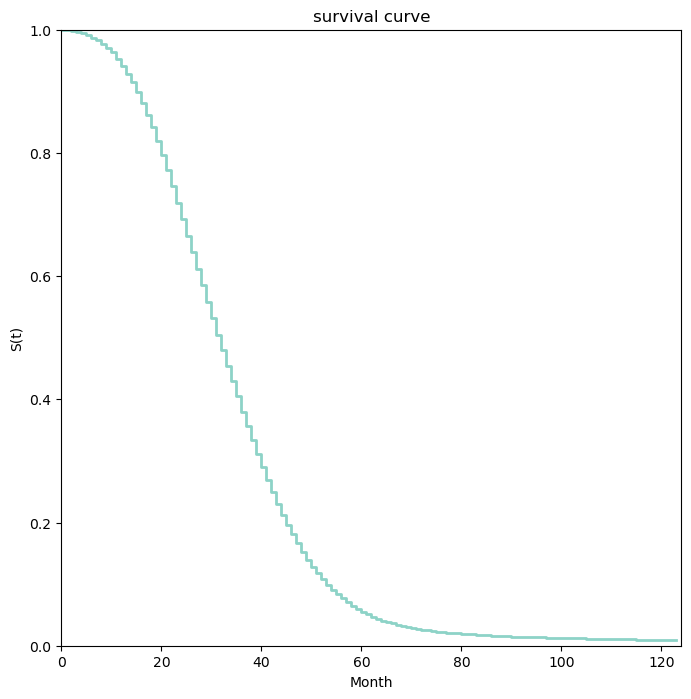

In [50]:
#然后通过计算出来的生存率绘制生存曲线
x = table["event_at"]
y =table["survival_rate"]
plt.figure(figsize=(8,8))
plt.title("survival curve") 
plt.step(x,y,color="#8dd3c7", where="pre",lw=2)
plt.xlim(0,124)
plt.ylim(0,1)
plt.xlabel("Month")
plt.ylabel('S(t)')
plt.show()


*  Kaplan-Meier法

In [69]:
p2p_full_data.loc[p2p_full_data["label"] ==np.nan]

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label


In [80]:
p2p_full_data.loc[pd.isnull(p2p_full_data["duration"])]

,name,operating_state,province_id,black_time,is_black,city_name,black_type,online_time,black_type_name,AdBlackType,...,TradingVolume,AveReturn,InvestorNum,AveLimTime,LoanNum,CumulateRepay,F30Repay,F60Repay,duration,label


In [78]:
p2p_full_data["duration"].median()

967.0

In [79]:
median=p2p_full_data["duration"].median()
p2p_full_data["duration"].fillna(median,inplace=True)

生成概率：
          KM_estimate
timeline             
-17.0        1.000000
-16.0        1.000000
-15.0        1.000000
-13.0        1.000000
-10.0        1.000000
...               ...
 3678.0      0.374073
 3680.0      0.249382
 3682.0      0.207819
 3684.0      0.124691
 3688.0      0.000000

[2877 rows x 1 columns]
中间存活概率=0.5时的，95%区间
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                  3672.0                  3680.0


<AxesSubplot:xlabel='timeline'>

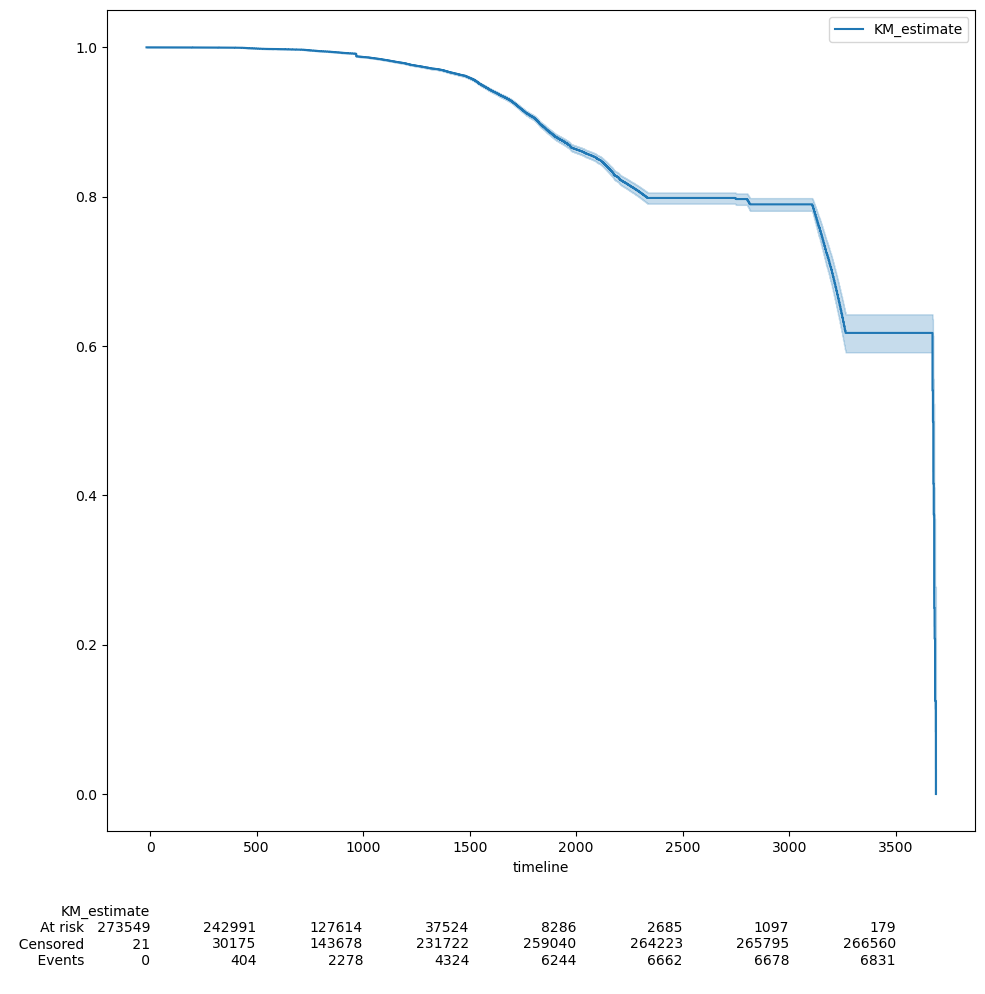

In [81]:
#使用KM分析，并绘制生存曲线和计算中位生存时间
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
kmf = KaplanMeierFitter()
kmf.fit(durations=p2p_full_data['duration'],
       event_observed=p2p_full_data['label'])

print("生成概率：")
print(kmf.survival_function_)
print("中间存活概率=0.5时的，95%区间")  
median_confidence_interval = median_survival_times(kmf.confidence_interval_)
print(median_confidence_interval)  #因为在研究期间生存概率没有低于0.5，所以没有中间生存概率对应的时间
plt.figure(figsize=[10,10])
kmf.plot_survival_function(at_risk_counts=True)#show_censors =True  是否显示删失 ，at_risk_counts=True 是否显示风险计数



In [ ]:
#打印生存曲线的简短统计内容(寿命表)。包括观察值，事件数，删失数，生存率和其置信区间。
pd.concat([kmf.event_table,kmf.survival_function_,kmf.confidence_interval_],axis=1)


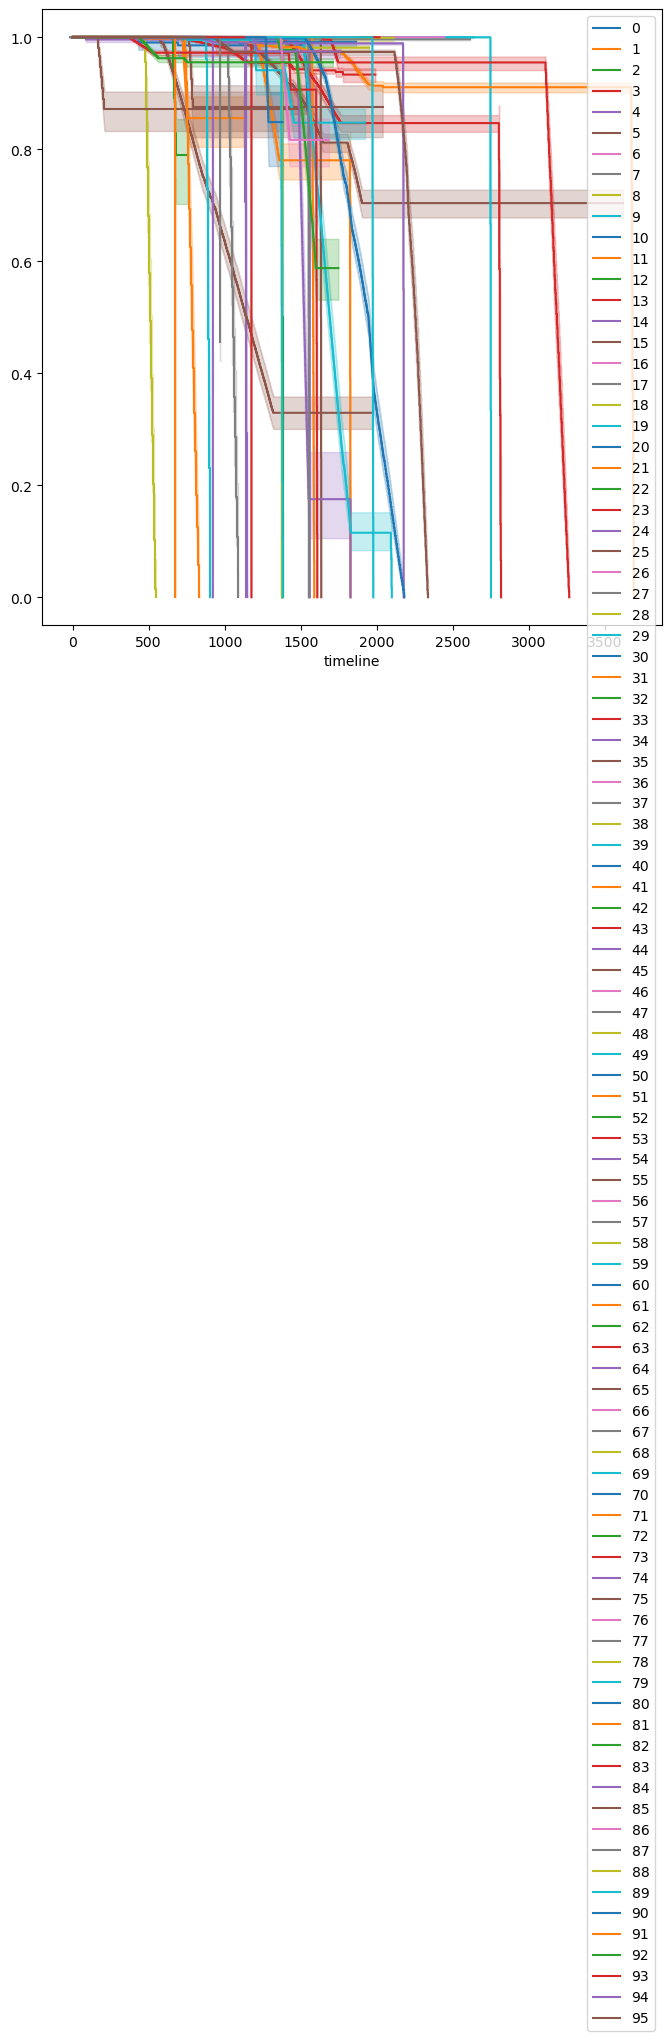

In [86]:
"""
对T——Stage 肿瘤大小进行分组并绘制生存曲线
从生存曲线中明显看到T4的患者（肿瘤大)的生存率下降比较快
"""
from lifelines import KaplanMeierFitter
plt.figure(figsize=(8,8))
kmf = KaplanMeierFitter()
for name, grouped_df in p2p_full_data.groupby('city_name'):
    kmf.fit(grouped_df["duration"], grouped_df["label"], label=name)
    kmf.plot_survival_function()

In [87]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

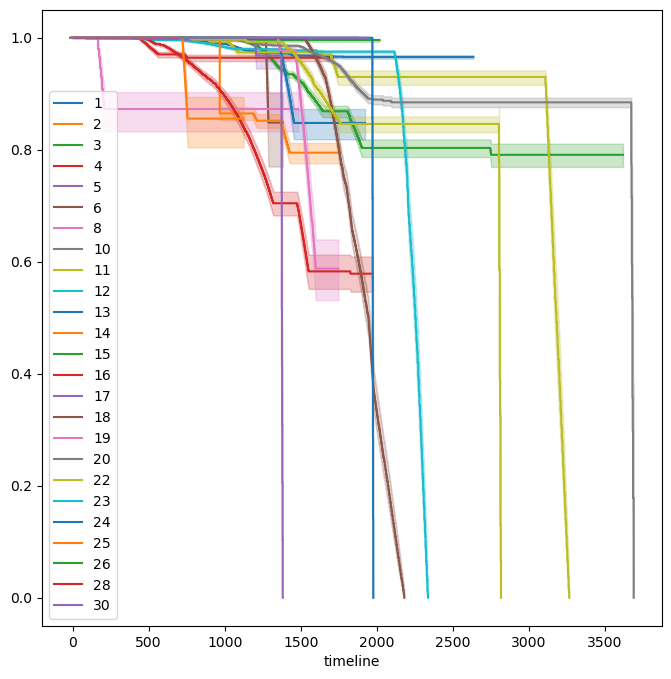

In [88]:
"""
对T——Stage 肿瘤大小进行分组并绘制生存曲线
从生存曲线中明显看到T4的患者（肿瘤大)的生存率下降比较快
"""
from lifelines import KaplanMeierFitter
plt.figure(figsize=(8,8))
kmf = KaplanMeierFitter()
for name, grouped_df in p2p_full_data.groupby('province_id'):
    kmf.fit(grouped_df["duration"], grouped_df["label"], label=name)
    kmf.plot_survival_function()

In [89]:
p2p_full_data.columns

Index(['name', 'operating_state', 'province_id', 'black_time', 'is_black',
       'city_name', 'black_type', 'online_time', 'black_type_name',
       'AdBlackType', 'FullName', 'TradingDate', 'PlatformID', 'TradingVolume',
       'AveReturn', 'InvestorNum', 'AveLimTime', 'LoanNum', 'CumulateRepay',
       'F30Repay', 'F60Repay', 'duration', 'label'],
      dtype='object')

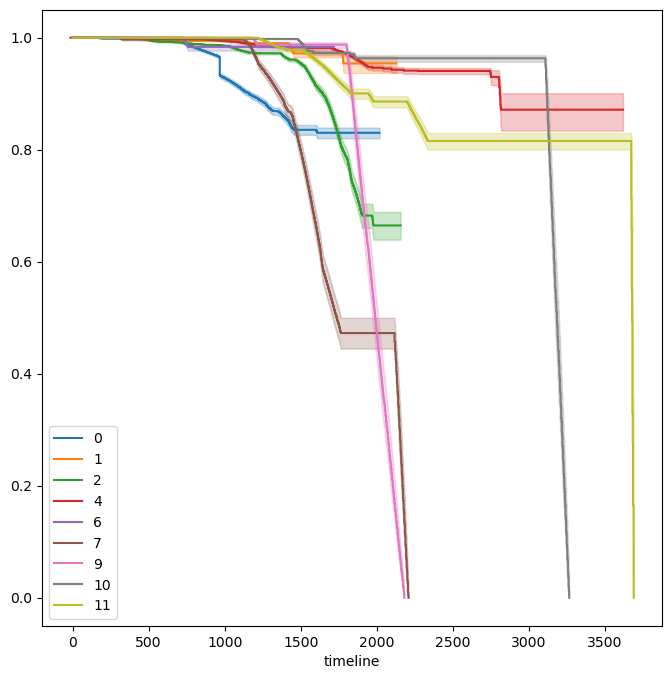

In [90]:
"""
对T——Stage 肿瘤大小进行分组并绘制生存曲线
从生存曲线中明显看到T4的患者（肿瘤大)的生存率下降比较快
"""
from lifelines import KaplanMeierFitter
plt.figure(figsize=(8,8))
kmf = KaplanMeierFitter()
for name, grouped_df in p2p_full_data.groupby('black_type'):
    kmf.fit(grouped_df["duration"], grouped_df["label"], label=name)
    kmf.plot_survival_function()

In [ ]:
"""
因为年龄是连续值，km法只适用分类变量，因为需要把连续值的年龄进行区间分组
对年龄进行分组，并绘制生存曲线
"""
# from lifelines import KaplanMeierFitter
# df['age_'] = pd.cut(df['Age'],[0,40,50,60])
# plt.figure(figsize=(8,8))
# kmf = KaplanMeierFitter()
# for name, grouped_df in df.groupby('age_'):
#     kmf.fit(grouped_df["duration"], grouped_df["label"], label=name)
#     kmf.plot_survival_function()


In [ ]:
"""
可以通过中位生存时间来比较两组之间的生存差异
（因为这个数据有些组的生存率最后都是大于0.5，无法计算中卫生存时间，所以显示inf）
"""

# from lifelines.utils import median_survival_times
# kmf = KaplanMeierFitter()
# for name, grouped_df in df.groupby('T_Stage'):
#     kmf_temp = KaplanMeierFitter().fit(grouped_df["Survival_Months"], grouped_df["Status"])
#     median = median_survival_times(kmf_temp)
#     print(f"{name}组的中位生存时间:{median}")


In [ ]:
"""
有些数据到随访结束时生存率都是大于0.5，即无法计算中位生存时间。
但是可以指定第qth分位数的生存时间，来求得对应的生存时间
"""

# from lifelines.utils import qth_survival_time
# qth = 0.9
# kmf = KaplanMeierFitter()
# for name, grouped_df in df.groupby('T_Stage'):
#     kmf_temp = KaplanMeierFitter().fit(grouped_df["Survival_Months"], grouped_df["Status"])
#     time = qth_survival_time(qth,kmf_temp)
#     print(f"{name}组的第{qth*100}分位数的生存时间:{time}")


In [ ]:
"""
可以通过指定时间来比较这个时间对应的生存差异（例如我关心的时第60个月的生存差异)
"""
# from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
# from lifelines.datasets import load_waltons

# T = df['Survival_Months']
# E = df['Status']
# ix = df['A_Stage']== 0
# kmf_1 = KaplanMeierFitter().fit(T[ix],  E[ix])
# kmf_2 = KaplanMeierFitter().fit(T[~ix],  E[~ix])

# point_in_time = 60. #指定比较的时间
# results = survival_difference_at_fixed_point_in_time_test(point_in_time, kmf_1, kmf_2)
# results.print_summary()


In [ ]:
"""
限制性平均生存时间/RMST
通过计算不同生存曲线下面积来比较生存差异
"""
from lifelines.utils import restricted_mean_survival_time
from lifelines.plotting import rmst_plot

T = df['Survival_Months']
E = df['Status']
ix = df['A_Stage']== 0 #0是'Regional'

time_limit = 60#指定T时间内

kmf_1 = KaplanMeierFitter().fit(T[ix], E[ix])
rmst_1 = restricted_mean_survival_time(kmf_1, t=time_limit)
print(f"曲线下面积:{rmst_1}")

kmf_2 = KaplanMeierFitter().fit(T[~ix], E[~ix])
rmst_2 = restricted_mean_survival_time(kmf_2, t=time_limit)
print(f"曲线下面积:{rmst_2}")

#把曲线面积绘制出来
plt.figure(figsize=(10,12))
ax = plt.subplot(311)
rmst_plot(kmf_1, t=time_limit, ax=ax)
ax = plt.subplot(312)
rmst_plot(kmf_2, t=time_limit, ax=ax)
ax = plt.subplot(313)
rmst_plot(kmf_1, model2=kmf_2, t=time_limit, ax=ax)


* 生存分析深度学习模型分析

In [177]:
class GCN(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super(GCN, self).__init__()
        self.g = g
        self.layers = nn.ModuleList()
        # input layer
        self.layers.append(GraphConv(in_feats, n_hidden, activation=activation))
        # output layer
        for i in range(n_layers - 1):
            self.layers.append(GraphConv(n_hidden, n_hidden, activation=activation))
        # output layer
        self.layers.append(GraphConv(n_hidden, n_classes))
        self.dropout = nn.Dropout(p=dropout)
    
    def forward(self, features):
        h = features
        for i, layers in enumerate(self.layers):
            if i!=0:
                h = self.dropout(h)
            h = layers(self.g, h)
        return h

In [ ]:
dropout=0.5
gpu=-1
lr=0.01
n_epochs=200
n_hidden=16  # 隐藏层节点的数量
n_layers=2  # 输入层 + 输出层的数量
weight_decay=5e-4  # 权重衰减
self_loop=True  # 自循环

In [ ]:
# cora 数据集

data = citegrh.load_cora()
features = torch.FloatTensor(data.features)
labels = torch.LongTensor(data.labels)
train_mask = torch.BoolTensor(data.train_mask)
val_mask = torch.BoolTensor(data.val_mask)
test_mask = torch.BoolTensor(data.test_mask)

in_feats = features.shape[1]
n_classes = data.num_labels
dataset = dgl.data.CoraGraphDataset()
g=dataset[0]
num_edge=g.num_edges()


In [ ]:
# 构建 DGLGraph
g = data[0]

In [ ]:
# 加载 GPU
if gpu < 0:
    cuda = False
else:
    cuda = True
    torch.cuda.set_device(gpu)
    features = features.cuda()
    labels = labels.cuda()
    train_mask = train_mask.cuda()
    val_mask = val_mask.cuda()
    test_mask = test_mask.cuda()

In [ ]:
dataset = dgl.data.CoraGraphDataset()
print('Number of categories:', dataset.num_classes)
g = dataset[0]
print('Node features')
print(g.ndata)
print('Edge features')
print(g.edata)


In [ ]:
class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes):
        super(GCN, self).__init__()
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        h = F.relu(h)
        h = self.conv2(g, h)
        return h


In [ ]:
def train(g, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    best_val_acc = 0
    best_test_acc = 0

    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(100):
        # Forward
        logits = model(g, features)

        # Compute prediction
        pred = logits.argmax(1)

        # Compute loss
        # Note that you should only compute the losses of the nodes in the training set.
        loss = F.cross_entropy(logits[train_mask], labels[train_mask])

        # Compute accuracy on training/validation/test
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()

        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % 5 == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))


# Create the model with given dimensions
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes)
print(model)
train(g, model)

In [ ]:
g.in_degrees()

In [ ]:
g = g.to('cuda')
model = GCN(g.ndata['feat'].shape[1], 16, dataset.num_classes).to('cuda')
train(g, model)

In [ ]:
class GraphSAGE(nn.Module):
    def __init__(self,
                 g,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout,
                 aggregator_type):
        super(GraphSAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.g = g
        # input layer
        self.layers.append(SAGEConv(in_feats, n_hidden, aggregator_type,
                                    feat_drop=dropout, activation=activation))
        # hidden layers
        for i in range(n_layers - 1):
            self.layers.append(SAGEConv(n_hidden, n_hidden, aggregator_type,
                                        feat_drop=dropout, activation=activation))
        # output layer
        self.layers.append(SAGEConv(n_hidden, n_classes, aggregator_type,
                                    feat_drop=dropout, activation=None)) # activation None
        
    def forward(self, features):
        h = features
        for layer in self.layers:
            h = layer(self.g, h)
        return h

In [ ]:
class SAGEConv(nn.Module):
    

    def __init__(self,
                 in_feats,
                 out_feats,
                 aggregator_type,
                 feat_drop=0.,
                 bias=True,
                 norm=None,
                 activation=None):
        super(SAGEConv, self).__init__()

        # expand_as_pair 函数可以返回一个二维元组。
        self._in_src_feats, self._in_dst_feats = expand_as_pair(in_feats)
        self._out_feats = out_feats
        self._aggre_type = aggregator_type
        self.norm = norm
        self.feat_drop = nn.Dropout(feat_drop)
        self.activation = activation
        # aggregator type: mean/pool/lstm/gcn
        if aggregator_type == 'pool':
            self.fc_pool = nn.Linear(self._in_src_feats, self._in_src_feats)
        if aggregator_type == 'lstm':
            self.lstm = nn.LSTM(self._in_src_feats, self._in_src_feats, batch_first=True)
        if aggregator_type != 'gcn':
            self.fc_self = nn.Linear(self._in_dst_feats, out_feats, bias=bias)
        self.fc_neigh = nn.Linear(self._in_src_feats, out_feats, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        """初始化参数
        这里的 gain 可以从 calculate_gain 中获取针对非线形激活函数的建议的值
        用于初始化参数
        """
        gain = nn.init.calculate_gain('relu')
        if self._aggre_type == 'pool':
            nn.init.xavier_uniform_(self.fc_pool.weight, gain=gain)
        if self._aggre_type == 'lstm':
            self.lstm.reset_parameters()
        if self._aggre_type != 'gcn':
            nn.init.xavier_uniform_(self.fc_self.weight, gain=gain)
        nn.init.xavier_uniform_(self.fc_neigh.weight, gain=gain)

    def _lstm_reducer(self, nodes):
        """LSTM reducer
        NOTE(zihao): lstm reducer with default schedule (degree bucketing)
        is slow, we could accelerate this with degree padding in the future.
        """
        m = nodes.mailbox['m'] # (B, L, D)
        batch_size = m.shape[0]
        h = (m.new_zeros((1, batch_size, self._in_src_feats)),
             m.new_zeros((1, batch_size, self._in_src_feats)))
        _, (rst, _) = self.lstm(m, h)
        return {'neigh': rst.squeeze(0)}

    def forward(self, graph, feat):
        """ SAGE 层的前向传播
        接收 DGLGraph 和 Tensor 格式的节点特征
        """
        # local_var 会返回一个作用在内部函数中使用的 Graph 对象
        # 外部数据的变化不会影响到这个 Graph
        # 可以理解为保护数据不被意外修改
        graph = graph.local_var()

        if isinstance(feat, tuple):
            feat_src = self.feat_drop(feat[0])
            feat_dst = self.feat_drop(feat[1])
        else:
            feat_src = feat_dst = self.feat_drop(feat)

        h_self = feat_dst

        # 根据不同的聚合类型选择不同的聚合方式
        # 值得注意的是，论文在 3.3 节只给出了三种聚合方式
        # 而这里却多出来一个 gcn 聚合
        # 具体原因将在后文给出
        if self._aggre_type == 'mean':
            graph.srcdata['h'] = feat_src
            graph.update_all(fn.copy_src('h', 'm'), fn.mean('m', 'neigh'))
            h_neigh = graph.dstdata['neigh']
        elif self._aggre_type == 'gcn':
            # check_eq_shape 用于检查源节点和目的节点的特征大小是否一致
            check_eq_shape(feat)
            graph.srcdata['h'] = feat_src
            graph.dstdata['h'] = feat_dst     # same as above if homogeneous
            graph.update_all(fn.copy_src('h', 'm'), fn.sum('m', 'neigh'))
            # divide in_degrees
            degs = graph.in_degrees().to(feat_dst)
            h_neigh = (graph.dstdata['neigh'] + graph.dstdata['h']) / (degs.unsqueeze(-1) + 1)
        elif self._aggre_type == 'pool':
            graph.srcdata['h'] = F.relu(self.fc_pool(feat_src))
            graph.update_all(fn.copy_src('h', 'm'), fn.max('m', 'neigh'))
            h_neigh = graph.dstdata['neigh']
        elif self._aggre_type == 'lstm':
            graph.srcdata['h'] = feat_src
            graph.update_all(fn.copy_src('h', 'm'), self._lstm_reducer)
            h_neigh = graph.dstdata['neigh']
        else:
            raise KeyError('Aggregator type {} not recognized.'.format(self._aggre_type))

        # GraphSAGE GCN does not require fc_self.
        if self._aggre_type == 'gcn':
            rst = self.fc_neigh(h_neigh)
        else:
            rst = self.fc_self(h_self) + self.fc_neigh(h_neigh)
        # activation
        if self.activation is not None:
            rst = self.activation(rst)
        # normalization
        if self.norm is not None:
            rst = self.norm(rst)
        return rst

In [ ]:
# GraphSAGE 的代码实现
class GraphSAGE(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(SAGEConv(in_feats, n_hidden, 'mean'))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, 'mean'))
        self.layers.append(SAGEConv(n_hidden, n_classes, 'mean'))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, blocks, x):
        # block 是我们采样获得的二部图，这里用于传播消息
        h = x
        for l, (layer, block) in enumerate(zip(self.layers, blocks)):
            h_dst = h[:block.number_of_dst_nodes()]
            h = layer(block, (h, h_dst))
            if l != len(self.layers) - 1:
                h = self.activation(h)
                h = self.dropout(h)
        return h

    def inference(self, g, x, batch_size, device):
        # 用于评估，针对的是完全图
        # 目前会出现重复计算的问题，优化方案还在 to do list 上
        nodes = th.arange(g.number_of_nodes())
        for l, layer in enumerate(self.layers):
            y = th.zeros(g.number_of_nodes(), self.n_hidden if l != len(self.layers) - 1 else self.n_classes)
            for start in tqdm.trange(0, len(nodes), batch_size):
                end = start + batch_size
                batch_nodes = nodes[start:end]
                block = dgl.to_block(dgl.in_subgraph(g, batch_nodes), batch_nodes)
                input_nodes = block.srcdata[dgl.NID]

                h = x[input_nodes].to(device)
                h_dst = h[:block.number_of_dst_nodes()]
                h = layer(block, (h, h_dst))
                if l != len(self.layers) - 1:
                    h = self.activation(h)
                    h = self.dropout(h)
                y[start:end] = h.cpu()
            x = y
        return y

In [ ]:
def prepare_mp(g):
    """
    一种临时的异构图内存解决方案
    """
    g.in_degree(0)
    g.out_degree(0)
    g.find_edges([0])

def compute_acc(pred, labels):
    """
    计算的准确率
    """
    return (th.argmax(pred, dim=1) == labels).float().sum() / len(pred)

def evaluate(model, g, inputs, labels, val_mask, batch_size, device):
    """
    评估模型
    """
    model.eval()
    with th.no_grad():
        pred = model.inference(g, inputs, batch_size, device)
    model.train()
    return compute_acc(pred[val_mask], labels[val_mask])

def load_subtensor(g, labels, seeds, input_nodes, device):
    """
    将一组节点的特征和标签复制到 GPU 上。
    """
    batch_inputs = g.ndata['features'][input_nodes].to(device)
    batch_labels = labels[seeds].to(device)
    return batch_inputs, batch_labels

In [ ]:
import torch  as th
import dgl.data.reddit as RedditDataset


gpu = -1
num_epochs = 20
num_hidden = 16
num_layers = 2
fan_out = '10,25'
batch_size = 1000
log_every = 20
eval_every = 5
lr = 0.003
dropout = 0.5
num_workers = 0

if gpu >= 0:
    device = th.device('cuda:%d' % gpu)
else:
    device = th.device('cpu')

# load reddit data
data = RedditDataset(self_loop=True)
train_mask = data.train_mask
val_mask = data.val_mask
features = th.Tensor(data.features)
in_feats = features.shape[1]
labels = th.LongTensor(data.labels)
n_classes = data.num_labels
# Construct graph
g = dgl.graph(data.graph.all_edges())
g.ndata['features'] = features
prepare_mp(g)

In [ ]:
train_nid = th.LongTensor(np.nonzero(train_mask)[0])
val_nid = th.LongTensor(np.nonzero(val_mask)[0])
train_mask = th.BoolTensor(train_mask)
val_mask = th.BoolTensor(val_mask)

# Create sampler
sampler = NeighborSampler(g, [int(fanout) for fanout in fan_out.split(',')])

# Create PyTorch DataLoader for constructing blocks
# collate_fn 参数指定了 sampler，可以对 batch 中的节点进行采样
dataloader = DataLoader(
    dataset=train_nid.numpy(),
    batch_size=batch_size,
    collate_fn=sampler.sample_blocks,
    shuffle=True,
    drop_last=False,
    num_workers=num_workers)

# Define model and optimizer
model = GraphSAGE(in_feats, num_hidden, n_classes, num_layers, F.relu, dropout)
model = model.to(device)
loss_fcn = nn.CrossEntropyLoss()
loss_fcn = loss_fcn.to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop
avg = 0
iter_tput = []
for epoch in range(num_epochs):
    tic = time.time()

    for step, blocks in enumerate(dataloader):
        tic_step = time.time()

        input_nodes = blocks[0].srcdata[dgl.NID]
        seeds = blocks[-1].dstdata[dgl.NID]

        # Load the input features as well as output labels
        batch_inputs, batch_labels = load_subtensor(g, labels, seeds, input_nodes, device)

        # Compute loss and prediction
        batch_pred = model(blocks, batch_inputs)
        loss = loss_fcn(batch_pred, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_tput.append(len(seeds) / (time.time() - tic_step))
        if step % log_every == 0:
            acc = compute_acc(batch_pred, batch_labels)
            gpu_mem_alloc = th.cuda.max_memory_allocated() / 1000000 if th.cuda.is_available() else 0
            print('Epoch {:05d} | Step {:05d} | Loss {:.4f} | Train Acc {:.4f} | Speed (samples/sec) {:.4f} | GPU {:.1f} MiB'.format(
                epoch, step, loss.item(), acc.item(), np.mean(iter_tput[3:]), gpu_mem_alloc))

    toc = time.time()
    print('Epoch Time(s): {:.4f}'.format(toc - tic))
    if epoch >= 5:
        avg += toc - tic
    if epoch % eval_every == 0 and epoch != 0:
        eval_acc = evaluate(model, g, g.ndata['features'], labels, val_mask, batch_size, device)
        print('Eval Acc {:.4f}'.format(eval_acc))

print('Avg epoch time: {}'.format(avg / (epoch - 4)))

In [ ]:
import dgl
import numpy as np
import torch as th
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.multiprocessing as mp
from torch.utils.data import DataLoader
import dgl.function as fn
import dgl.nn.pytorch as dglnn
import time
import argparse
from _thread import start_new_thread
from functools import wraps
from dgl.data import RedditDataset
import tqdm
import traceback

#### Neighbor sampler

class NeighborSampler(object):
    def __init__(self, g, fanouts):
        self.g = g
        self.fanouts = fanouts

    def sample_blocks(self, seeds):
        seeds = th.LongTensor(np.asarray(seeds)) #这个seed一开始是dataloader里的batchsampler，按照batch大小依次把graph的id一个个yeild出来
        blocks = []
        for fanout in self.fanouts: #[10,25]
            # For each seed node, sample ``fanout`` neighbors. 这里的sampler是在v0.4.3版本新加入
            frontier = dgl.sampling.sample_neighbors(g, seeds, fanout, replace=True) #利用1000个seeds得到的10000个边？节点
            # Then we compact the frontier into a bipartite graph for message passing.
            block = dgl.to_block(frontier, seeds) # to_black操作是把将采样的子图转换为适合计算的二部图,这里特殊的地方在于block.srcdata中的id是包含了dstnodeid的
            # Obtain the seed nodes for next layer.
            seeds = block.srcdata[dgl.NID]
            # 一个种子的长度是1000，就是一个batch的索引,1000个一个batch，采样10个邻居，得到10000边9640个点，再采样25个点，得到241000个边，105693个点，Blocks里面是两个子图
            blocks.insert(0, block)
        return blocks

class SAGE(nn.Module):
    def __init__(self,
                 in_feats,
                 n_hidden,
                 n_classes,
                 n_layers,
                 activation,
                 dropout):
        super().__init__()
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_classes = n_classes
        self.layers = nn.ModuleList()
        self.layers.append(dglnn.SAGEConv(in_feats, n_hidden, 'mean'))
        for i in range(1, n_layers - 1):
            self.layers.append(dglnn.SAGEConv(n_hidden, n_hidden, 'mean'))
        self.layers.append(dglnn.SAGEConv(n_hidden, n_classes, 'mean'))
        self.dropout = nn.Dropout(dropout)
        self.activation = activation

    def forward(self, blocks, x):
        h = x #第一轮输入的x就是采样两次后的二阶相邻点，维度是10w+*602，其实g.ndata的原始标签
        for l, (layer, block) in enumerate(zip(self.layers, blocks)):
            # We need to first copy the representation of nodes on the RHS from the，两层SAGEConv分别对应两个block
            # appropriate nodes on the LHS.
            # Note that the shape of h is (num_nodes_LHS, D) and the shape of h_dst
            # would be (num_nodes_RHS, D)，blocks0是左9640右10w+的二部图，block1是左1000右9640的二部图
            h_dst = h[:block.number_of_dst_nodes()] # 每一阶的节点里面都包含了他的dst节点在序列的最前面，方便计算。但是这个是怎么抽样的？dgl.to_blockd函数定义里有说。。
            # Then we compute the updated representation on the RHS.
            # The shape of h now becomes (num_nodes_RHS, D)
            h = layer(block, (h, h_dst)) #block是dglnn.SAGEConv().forward(graph,feat)中的graph,feat=(h,h_dst)，h是10w的起始节点特征，h_dst是目的节点的特征
            if l != len(self.layers) - 1: #当汇聚方式是mean的时候，SAGEConv实现了，把h的所有特征发送到dst节点，根据dst节点求平均，加上dst节点的原始特征，接一个fc层输出dst节点的新的特征，如果是gcn的话，其实跟mean基本一样，具体可以看dglnn.SAGEConv里面的4种聚合函数的定义，所谓定义graphsage需要学习的参数权重就是这里SAGEConv内部的权重，比如这里602的维度转换为41的权重。
                h = self.activation(h)
                h = self.dropout(h)
        return h

    def inference(self, g, x, batch_size, device):
        """
        Inference with the GraphSAGE model on full neighbors (i.e. without neighbor sampling).
        g : the entire graph.
        x : the input of entire node set.

        The inference code is written in a fashion that it could handle any number of nodes and
        layers.
        """
        # During inference with sampling, multi-layer blocks are very inefficient because
        # lots of computations in the first few layers are repeated.
        # Therefore, we compute the representation of all nodes layer by layer.  The nodes
        # on each layer are of course splitted in batches.
        # TODO: can we standardize this?
        nodes = th.arange(g.number_of_nodes())
        for l, layer in enumerate(self.layers):
            y = th.zeros(g.number_of_nodes(), self.n_hidden if l != len(self.layers) - 1 else self.n_classes)

            for start in tqdm.trange(0, len(nodes), batch_size):
                end = start + batch_size
                batch_nodes = nodes[start:end]
                block = dgl.to_block(dgl.in_subgraph(g, batch_nodes), batch_nodes)
                input_nodes = block.srcdata[dgl.NID]

                h = x[input_nodes].to(device)
                h_dst = h[:block.number_of_dst_nodes()]
                h = layer(block, (h, h_dst))
                if l != len(self.layers) - 1:
                    h = self.activation(h)
                    h = self.dropout(h)

                y[start:end] = h.cpu()

            x = y
        return y

def prepare_mp(g):
    """
    Explicitly materialize the CSR, CSC and COO representation of the given graph
    so that they could be shared via copy-on-write to sampler workers and GPU
    trainers.

    This is a workaround before full shared memory support on heterogeneous graphs.
    """
    g.in_degree(0)
    g.out_degree(0)
    g.find_edges([0])

def compute_acc(pred, labels):
    """
    Compute the accuracy of prediction given the labels.
    """
    return (th.argmax(pred, dim=1) == labels).float().sum() / len(pred)

def evaluate(model, g, inputs, labels, val_mask, batch_size, device):
    """
    Evaluate the model on the validation set specified by ``val_mask``.
    g : The entire graph.
    inputs : The features of all the nodes.
    labels : The labels of all the nodes.
    val_mask : A 0-1 mask indicating which nodes do we actually compute the accuracy for.
    batch_size : Number of nodes to compute at the same time.
    device : The GPU device to evaluate on.
    """
    model.eval()
    with th.no_grad():
        pred = model.inference(g, inputs, batch_size, device)
    model.train()
    return compute_acc(pred[val_mask], labels[val_mask])

def load_subtensor(g, labels, seeds, input_nodes, device):
    """
    Copys features and labels of a set of nodes onto GPU.
    """
    batch_inputs = g.ndata['features'][input_nodes].to(device)
    batch_labels = labels[seeds].to(device)
    return batch_inputs, batch_labels

#### Entry point
def run(args, device, data):
    # Unpack data, in_feats=602 ,nodes=232965 ,edges=114848857,n_classes=41，train_nid 13w训练样本的id
    train_mask, val_mask, in_feats, labels, n_classes, g = data
    train_nid = th.LongTensor(np.nonzero(train_mask)[0]) #np.nonzeros()返回元组(分别描述非0元素的位置二维)
    val_nid = th.LongTensor(np.nonzero(val_mask)[0])
    train_mask = th.BoolTensor(train_mask)
    val_mask = th.BoolTensor(val_mask)

    # Create sampler初始化，默认的fanout是10,25，这个的意思是一阶抽10倍，2阶抽25倍
    sampler = NeighborSampler(g, [int(fanout) for fanout in args.fan_out.split(',')])

    # Create PyTorch DataLoader for constructing blocks,train—id是15w的数据索引，batch=1000，sampler抽样器，
    dataloader = DataLoader(
        dataset=train_nid.numpy(),
        batch_size=args.batch_size,
        collate_fn=sampler.sample_blocks, #样本不能被batch整除时，需要的处理函数，这里其实是对1000个种子id做抽样，返回block二部图的方法
        shuffle=True,
        drop_last=False,
        num_workers=args.num_workers)

    # Define model and optimizer ，输入维度602，隐层16,n_classes =41
    model = SAGE(in_feats, args.num_hidden, n_classes, args.num_layers, F.relu, args.dropout)
    model = model.to(device)
    loss_fcn = nn.CrossEntropyLoss()
    loss_fcn = loss_fcn.to(device)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    # Training loop
    avg = 0
    iter_tput = []
    for epoch in range(args.num_epochs):
        tic = time.time()

        # Loop over the dataloader to sample the computation dependency graph as a list of
        # blocks.
        for step, blocks in enumerate(dataloader):
            tic_step = time.time()

            # The nodes for input lies at the LHS side of the first block.
            # The nodes for output lies at the RHS side of the last block.
            input_nodes = blocks[0].srcdata[dgl.NID] #block0是一个二部图，就是左边9640右边105693个节点(每次采样数量会有变化!!)，边是2410000的二部图，
            seeds = blocks[-1].dstdata[dgl.NID] #seed是种子点1000个，一阶采样是10个边，得到1000-9640的二部图block1,在用9640采样25边，得到9640-105693的二部图block0

            # Load the input features as well as output labels,这里类似把这二hop的105693*603的矩阵作为输出，最后输出的是1000个点。
            batch_inputs, batch_labels = load_subtensor(g, labels, seeds, input_nodes, device) #input_nodes是二阶点的id,batch_inputs是二阶点对应的特征

            # Compute loss and prediction
            batch_pred = model(blocks, batch_inputs)
            loss = loss_fcn(batch_pred, batch_labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            iter_tput.append(len(seeds) / (time.time() - tic_step))
            if step % args.log_every == 0:
                acc = compute_acc(batch_pred, batch_labels)
                gpu_mem_alloc = th.cuda.max_memory_allocated() / 1000000 if th.cuda.is_available() else 0
                print('Epoch {:05d} | Step {:05d} | Loss {:.4f} | Train Acc {:.4f} | Speed (samples/sec) {:.4f} | GPU {:.1f} MiB'.format(
                    epoch, step, loss.item(), acc.item(), np.mean(iter_tput[3:]), gpu_mem_alloc))

        toc = time.time()
        print('Epoch Time(s): {:.4f}'.format(toc - tic))
        if epoch >= 5:
            avg += toc - tic
        if epoch % args.eval_every == 0 and epoch != 0:
            eval_acc = evaluate(model, g, g.ndata['features'], labels, val_mask, args.batch_size, device)
            print('Eval Acc {:.4f}'.format(eval_acc))

    print('Avg epoch time: {}'.format(avg / (epoch - 4)))

if __name__ == '__main__':
    argparser = argparse.ArgumentParser("multi-gpu training")
    argparser.add_argument('--gpu', type=int, default=0,
        help="GPU device ID. Use -1 for CPU training")
    argparser.add_argument('--num-epochs', type=int, default=20)
    argparser.add_argument('--num-hidden', type=int, default=16)
    argparser.add_argument('--num-layers', type=int, default=2)
    argparser.add_argument('--fan-out', type=str, default='10,25')
    argparser.add_argument('--batch-size', type=int, default=1000)
    argparser.add_argument('--log-every', type=int, default=20)
    argparser.add_argument('--eval-every', type=int, default=5)
    argparser.add_argument('--lr', type=float, default=0.003)
    argparser.add_argument('--dropout', type=float, default=0.5)
    argparser.add_argument('--num-workers', type=int, default=0,
        help="Number of sampling processes. Use 0 for no extra process.")
    
    args = argparser.parse_args()
    print(argparser.parse_args())
    if args.gpu >= 0:
        device = th.device('cuda:%d' % args.gpu)
    else:
        device = th.device('cpu')

    # load reddit data
    data = RedditDataset(self_loop=True)
    train_mask = data.train_mask
    val_mask = data.val_mask
    features = th.Tensor(data.features)
    in_feats = features.shape[1]
    labels = th.LongTensor(data.labels)
    n_classes = data.num_labels
    # Construct graph
    g = dgl.graph(data.graph.all_edges())
    g.ndata['features'] = features
    prepare_mp(g)
    # Pack data
    data = train_mask, val_mask, in_feats, labels, n_classes, g

    run(args, device, data)

In [ ]:
%tb